# Second notebook on the analysis of P170+20
Second stage of the analysis focused on quantitative model comparison 
and best-fit selection.

In the first notebook, the observational data were normalized, rescaled 
to photometric reference points, resampled into uniform wavelength bins, 
and tested against preliminary stellar (M, L, T brown dwarfs / cool stars) 
and quasar/galaxy templates.

This notebook:

- Resamples the finalized dataset and template models under consistent binning
- Applies uniform scaling conditions
- Compares stellar and quasar/galaxy templates
- Evaluates goodness-of-fit across candidate models
- Identifies the most plausible physical scenario
- Produces comparative visualizations of the best-fit model

The objective is structured hypothesis evaluation through controlled 
template-based model comparison.


In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot  as plt
import astropy
from astropy.io import fits
from photutils.aperture import aperture_photometry
#not. sure about these two
from photutils.aperture import CircularAnnulus, CircularAperture, SkyCircularAperture, SkyCircularAnnulus 
from photutils.aperture import ApertureStats
from astropy.visualization import simple_norm
from astropy.wcs import WCS
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
#from sculptor import speconed as sod
#import pkg_resources
from astropy import units as u
#from sculptor import speconed as sod
from astropy import units as u
from astropy.table import Table
from scipy.optimize import curve_fit
import pkg_resources

/tmp/ipykernel_80547/1129637220.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
#Redshift of the object-changed during the analysis
z=6.38

<Table length=960>
    name     dtype   unit                 description                
----------- ------- ------ ------------------------------------------
       Wave float64 0.1 nm                    Wavelength in Angstroms
      FluxD float64     --        Flux density PS1 composite spectrum
          N   int64     --       Number of quasars per wavelength bin
FluxD(hlya) float64     -- Flux density strong lya composite spectrum
FluxD(llya) float64     --   Flux density weak lya composite spectrum


(7380.0, 10918.71)

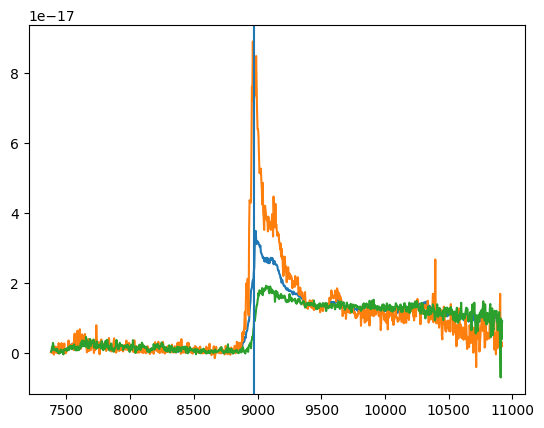

In [3]:
#Upload different templates for analysis / Banados et al.,2016
compositehrspectra=Table.read('compositespectra.txt',format='ascii')
compositehrspectra.info()
composite_flux=compositehrspectra['FluxD']*1e-16/(z+1)
composite_fluxhl=compositehrspectra['FluxD(hlya)']*1e-16/(z+1)
composite_fluxll=compositehrspectra['FluxD(llya)']*1e-16/(z+1)
composite_wave=compositehrspectra['Wave']*(z+1)
plt.plot(composite_wave,composite_flux)
plt.plot(composite_wave,composite_fluxhl)
plt.plot(composite_wave,composite_fluxll)
plt.axvline(1216*(z+1))
composite_wave[0],composite_wave[-1]

(7380.738, 83760.78600000001)

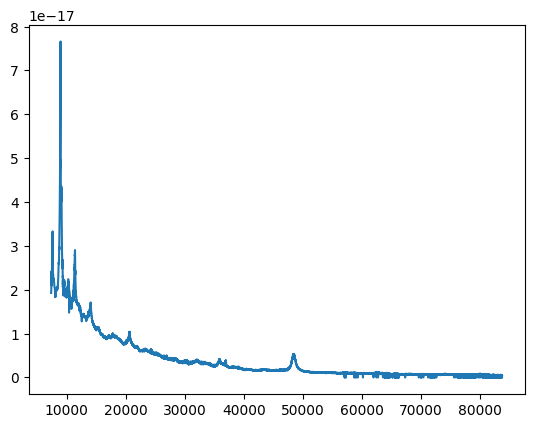

In [4]:
data = np.loadtxt('Selsing2015.dat', delimiter=' ')
wl=data[:,0]*(z+1)
weighted_mean=data[:,1]*1e-17/(z+1)
error_of_weighted_mean=data[:,2]*1e-17/(z+1)
plt.plot(wl,weighted_mean)
#Lowering Selsing values to W1 value and mask to join to Banados data
factor=4.7 #W1 factor

#last wavelenght 1479.5
maskcs=wl>1479.5*(z+1)
selsingflux=weighted_mean[maskcs]#/factor
wl[0],wl[-1]

In [5]:
#Load original data
originaldata=Table.read('spectra_gmos_fla_2_v2.txt', format='ascii')
originaldata.info

<Table length=4588>
   name     dtype 
---------- -------
WAVELENGTH float64
      FLUX float64
       ERR float64

In [6]:
originaldata['WAVELENGTH'][0:-1]

<Column name='WAVELENGTH' dtype='float64' length=4587>
 7144.467185079627
 7145.225464552703
 7145.983744025784
 7146.742023498863
  7147.50030297194
 7148.258582445018
 7149.016861918096
 7149.775141391177
 7150.533420864256
 7151.291700337333
 7152.049979810413
 7152.808259283491
               ...
 24110.64732458769
24118.163234501826
 24125.67871609752
24133.194030285562
24140.709015606586
24148.223922675097
 24155.73838534946
24163.252591457196
 24170.76656527881
 24178.28028263741
24185.793647017344

        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]


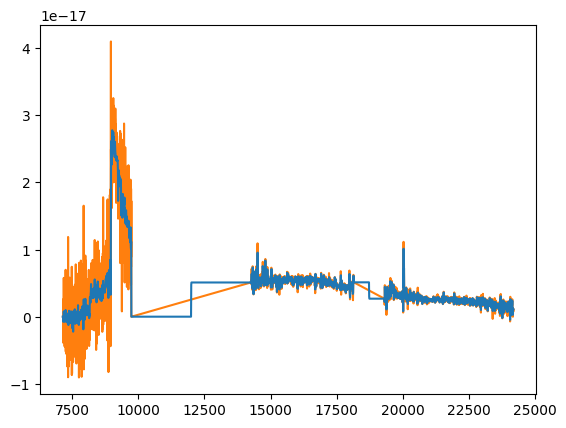

In [7]:
#Resample original data - We need all out data in the same grid so we can perform the analysis
#Try to do the resample here
#Include resample data/ pix_size=7.7
import astropy.units as units
from specutils.manipulation import FluxConservingResampler
#First Give units to variables with filtered data
#Total data
newflux=originaldata['FLUX']* units.erg/units.s/units.cm**2/units.AA
newwave=originaldata['WAVELENGTH']*1.*units.AA
newerr=originaldata['ERR'] * units.erg/units.s/units.cm**2/units.AA

#convert to Spectrum from specutils 
from specutils import Spectrum1D
input_spec=Spectrum1D(spectral_axis=newwave,flux=newflux) 
input_spec_err=Spectrum1D(spectral_axis=newwave,flux=newerr)

#Resample here-7.7 pixel size GMOS optical data
new_disp_grid = np.arange(5300, 24185.793, 7.7) * u.AA
#new_disp_grid = np.arange(7144.467, 24185.793, 7.7) * u.AA #inwave,finwave,pixsize
fluxcon = FluxConservingResampler()
new_spec_fluxcon = fluxcon(input_spec, new_disp_grid)
new_spec_fluxcon_err = fluxcon(input_spec_err, new_disp_grid)

#Plot previous combined data-resample data
plt.plot(new_spec_fluxcon.spectral_axis,new_spec_fluxcon.flux)
plt.plot(newwave,newflux,zorder=1)

        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]


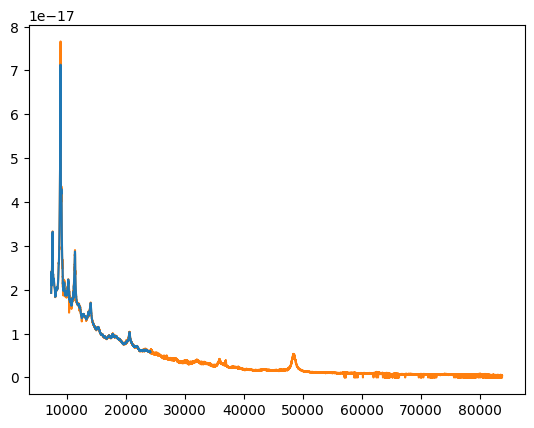

In [8]:
#Resample templates ----> Selsing et al.,2015
#Try to do the resample here
#Include resample data/ pix_size=7.7
import astropy.units as units
from specutils.manipulation import FluxConservingResampler
#First Give units to variables with filtered data
#Total data
newfluxs=weighted_mean* units.erg/units.s/units.cm**2/units.AA
newwaves=wl*units.AA
newerrs=error_of_weighted_mean* units.erg/units.s/units.cm**2/units.AA

#convert to Spectrum from specutils 
from specutils import Spectrum1D
input_specs=Spectrum1D(spectral_axis=newwaves,flux=newfluxs) 
input_spec_errs=Spectrum1D(spectral_axis=newwaves,flux=newerrs)

#Resample here
#new_disp_grids = np.arange(7370.737, 83644.341, 7.7) * u.AA #inwave,finwave,pixsize
fluxcons = FluxConservingResampler()
new_spec_fluxcons = fluxcons(input_specs, new_disp_grid)
new_spec_fluxcon_errs = fluxcons(input_spec_errs, new_disp_grid)

#Resample data is cut since we dont need for our analysis the rrest of the wavelengths
plt.plot(new_spec_fluxcons.spectral_axis,new_spec_fluxcons.flux)
plt.plot(newwaves,newfluxs,zorder=1)

        Use Spectrum instead. [warnings]


<SpectralAxis 5300. Angstrom>

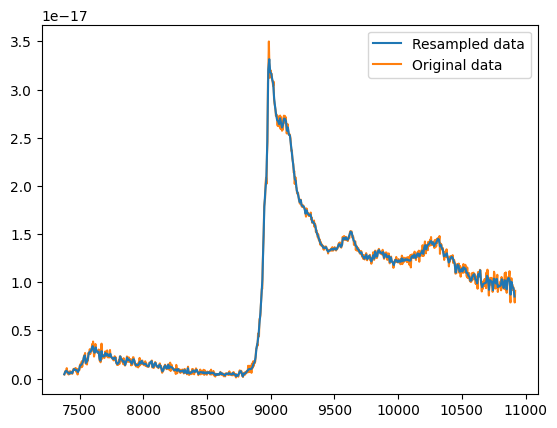

In [9]:
#Resample templates ----> Banados Intermediate
#Try to do the resample here
#Include resample data/ pix_size=7.7

#First Give units to variables with filtered data
#Total data
import astropy.units as units
newfluxc=composite_flux.value*units.erg/units.s/units.cm**2/units.AA #here to change to l
newwavec=composite_wave.value*1.*units.AA

#convert to Spectrum from specutils 
from specutils import Spectrum1D
input_specc=Spectrum1D(spectral_axis=newwavec,flux=newfluxc) 

#Resample here
#new_disp_gridc = np.arange(7156.777720705721, 10900.23, 7.7) * u.AA #inwave,finwave,pixsize
fluxconc = FluxConservingResampler()
new_spec_fluxconc = fluxcon(input_specc, new_disp_grid)

plt.plot(new_spec_fluxconc.spectral_axis,new_spec_fluxconc.flux,label='Resampled data')
plt.plot(newwavec,newfluxc,zorder=1,label='Original data')
plt.legend()
new_spec_fluxconc.spectral_axis[0]

##  RESAMPLED DATA from templates
 Join Intermediate Comp Spectra the Lyman alpha break with Selsing in the last point of the wavelenght

In [10]:
#Rename resampled data again
#Original data
originaldata_wave=new_spec_fluxcon.spectral_axis.value
originaldata_flux=new_spec_fluxcon.flux.value
#Selsing data
wl=new_spec_fluxcons.spectral_axis.value
weighted_mean=new_spec_fluxcons.flux.value
#Banados data composite/intermediate
composite_wave=new_spec_fluxconc.spectral_axis.value
composite_flux=new_spec_fluxconc.flux.value
composite_wave[0]

5300.0

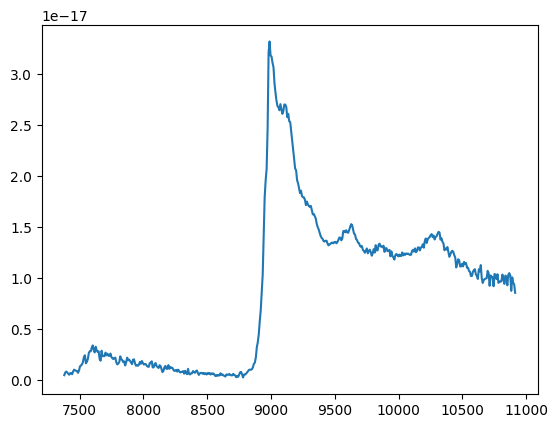

In [11]:
plt.plot(composite_wave,composite_flux)

In [12]:
#lAST WAVE IN banados
composite_wave[-1],1479.5*(z+1)

(24180.399999999554, 10918.71)

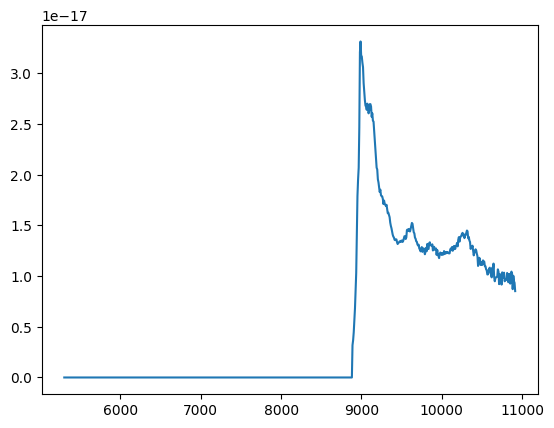

In [13]:
#set banados data to zero before the break
maskzero=composite_wave < 1216*(1+z)-90 
composite_flux= np.where(maskzero, 0, composite_flux)
plt.plot(composite_wave,composite_flux)

968.1571815718157

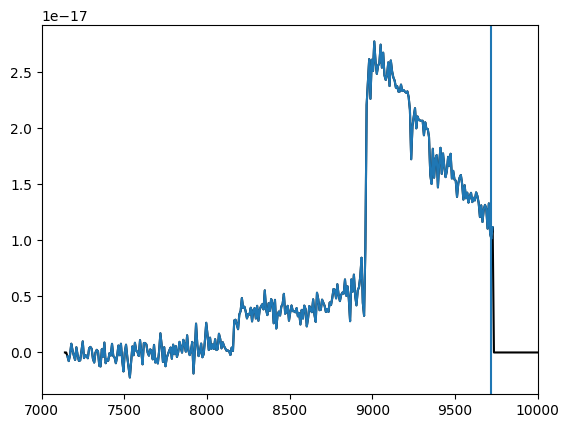

In [14]:
plt.plot(originaldata_wave,originaldata_flux,color='black')
maskcurve=(originaldata_wave>969.47*(z+1))&(originaldata_wave<1318.86*(1+z))
plt.plot(originaldata_wave[maskcurve],originaldata_flux[maskcurve])
plt.xlim(7000, 10000)
plt.axvline(9720)
originaldata_wave[0]
7145/(z+1)

# Plot data with templates

(2453, 2453, 0.590988126431837, 1470.189701897019, 1476.9647696476966)

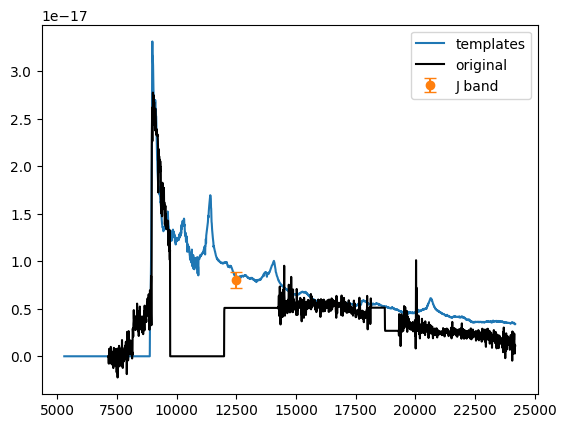

In [15]:
#Scale Selsing with comp lyman AND plot photometric point in J band for comparison.
maskcs2=wl>1479.5*(z+1)
maskpr=composite_wave<1479.5*(z+1)

masksjoin=(wl>10850)&(wl<10900)
selsingjoin=(composite_wave>10850)&(composite_flux<10900)
avgbanadosjoin=np.median(composite_flux[masksjoin])
averageselsingjoin=np.median(weighted_mean[selsingjoin])
averagejoin=avgbanadosjoin/averageselsingjoin

factorq=averagejoin#1.8#3.6 to match W1, 1.8 J band
factorj=4.2

#CREATE NEW QSO TEMPLATE
tabc = astropy.table.Table()
tabc['WAVE']= np.append(composite_wave[maskpr],wl[maskcs2])
tabc['FLUX']= np.append(composite_flux[maskpr],weighted_mean[maskcs2]*factorq) #composite_fluxhl*factorc
#plt.plot(wl[selsingjoin], weighted_mean[selsingjoin],label='zone',color='magenta')
plt.plot(tabc['WAVE'],tabc['FLUX'],label='templates')
plt.plot(originaldata_wave,originaldata_flux,label='original',color='black')
#plt.errorbar(x=34000, y=7.19e-19, yerr=0.85e-18, fmt='o', capsize=4,label='W1 band')
#plt.errorbar(x=46000, y=2.28e-19, yerr=0.8e-18, fmt='o', capsize=4,label='W2 band')
#plt.plot(data[:,0]*(z+1),(data[:,1]*1e-17/(z+1))/factorj,label='selsing template') #to match with j band
plt.errorbar(x=12500, y=8.014e-18, yerr=0.85e-18, fmt='o', capsize=4,label='J band')
#plt.xlim(10000,12000)# to check break
#plt.xlim(30000,40000) #to check WI factors3=3.6
#plt.xlim(10000,13000) #to check the j band
#hERE TO CHeCK W1
#plt.plot(newwaves,newfluxs/2.1,zorder=1)
#plt.plot(composite_wave,composite_flux,label='banados template',linestyle='dotted')
#plt.plot(wl,weighted_mean,label='selsing template')
tabc['FLUX'][27]
plt.legend()

len(tabc['FLUX']),len(originaldata_flux),averagejoin,10850/(z+1),10900/(z+1)


# #fit residual qso to template
maskresqso1=(originaldata_wave>969.47*(z+1))&(originaldata_wave<1210*(1+z))
maskresqso2=(originaldata_wave>1940.29*(z+1))&(originaldata_wave<2469.47*(z+1))
maskresqso3=(originaldata_wave>2618.72*(z+1))&(originaldata_wave<3283.58*(z+1))
maskresqso=maskresqso1|maskresqso2|maskresqso3
bdscale=new_spec_fluxconbd.flux.value*factorcbd
residualbddata=originaldata_flux-bdscale
residualbddatac=residualbddata[maskresqso]
plt.plot(originaldata_wave,residualbddata)
def residual(x,c):
    f = c*residualbddatac
    return f


#mask_no_nan = ~np.isnan(tabc['FLUX'])
popt2,pcov2=curve_fit(residual,xdata=tabc['WAVE'][maskresqso],ydata=tabc['FLUX'][maskresqso],p0=[4.2])
factorcresqso=popt2[0]

factorcresqso

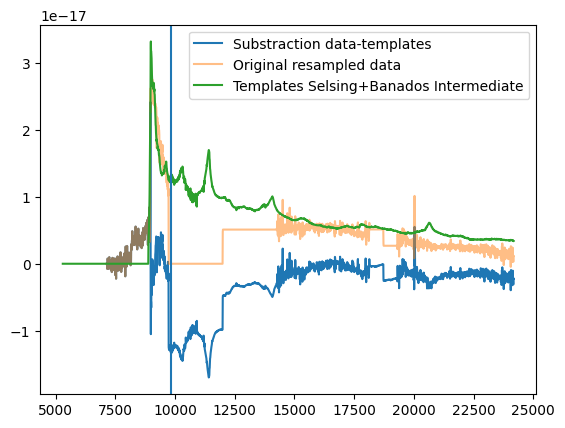

In [16]:
#Now the substraction

#Substraction data-model CLyman/Selsing
maskl=originaldata_wave>1216*(1+z) #mask to rest from Lyman alpha
maskl2=originaldata_wave<1216*(1+z)
a=originaldata_flux#[maskl]
d=tabc['FLUX']

result3 = a-d 
residual3=np.append(originaldata_flux[maskl2],result3[maskl]) #resta de data -templates sin contar zona mas alla de lyman


plt.plot(originaldata_wave,  residual3,label='Substraction data-templates' )
plt.plot(originaldata_wave,originaldata_flux,alpha=0.5,label='Original resampled data')
plt.plot(tabc['WAVE'],tabc['FLUX'],zorder=2,label='Templates Selsing+Banados Intermediate')
#plt.xlim(7700,10000)
plt.legend()
plt.axvline(1330*(z+1))

# Here we test our model
The function Mdarf_function loops over all the available spectra from M brown dwarfs. First resample the the spectrum of M-dwarf, fit the spectrum to our GMOS-F2 data in a wavelength range below 1215 angstroms. Then we found the residual spectra and we fit the combined quasar spectra from the templates. The final model Mdwarf-quasar(2 templates) and a chi square test to find the spectrum who has the best fit for our data.  

        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]


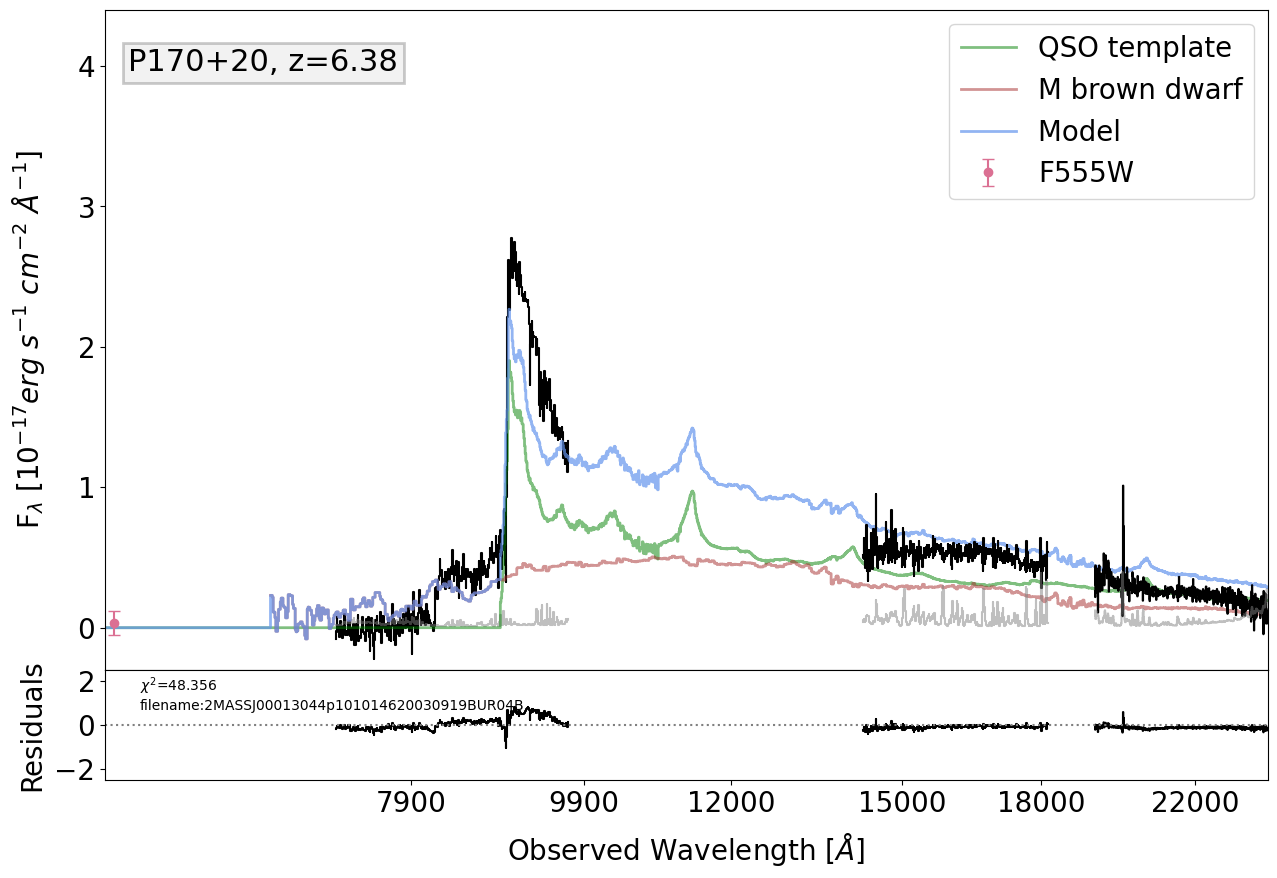

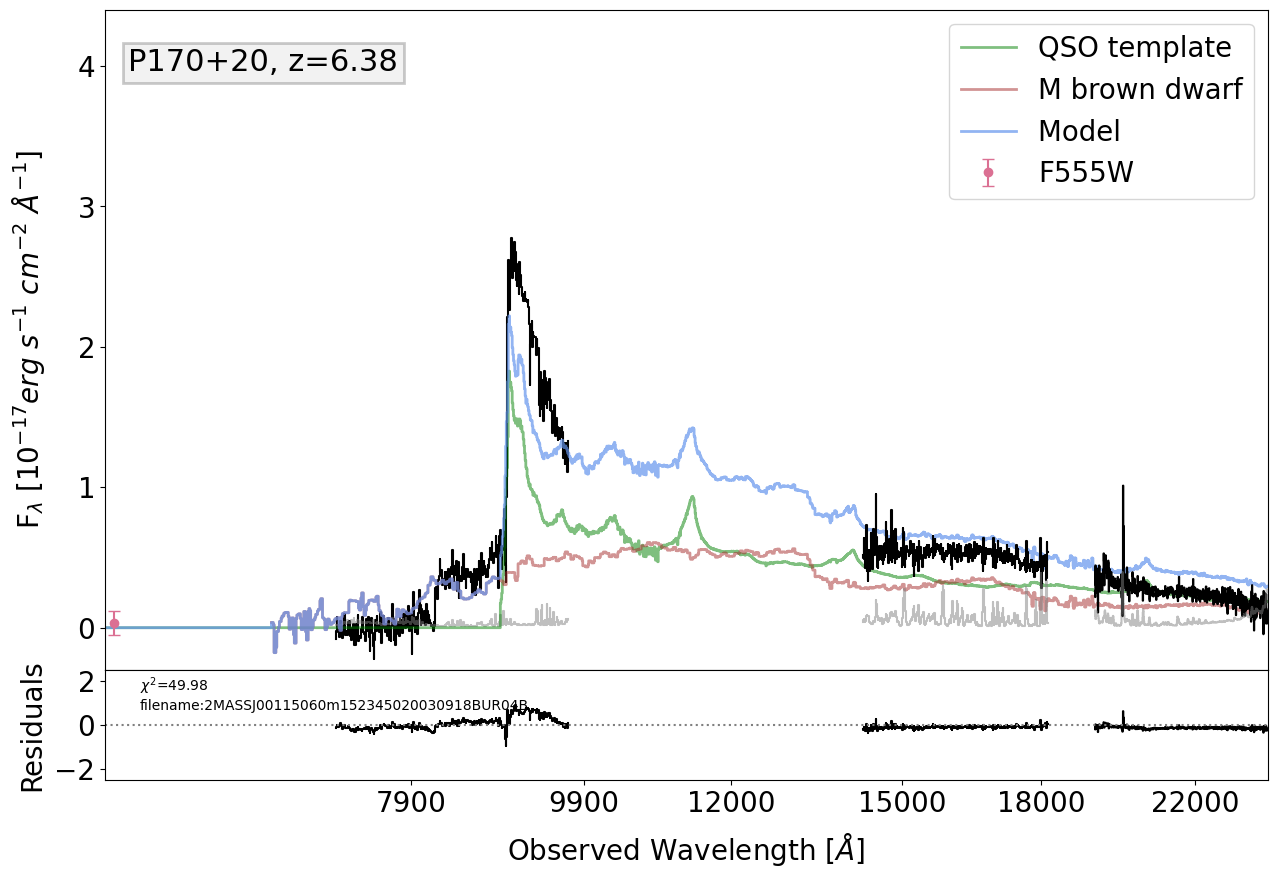

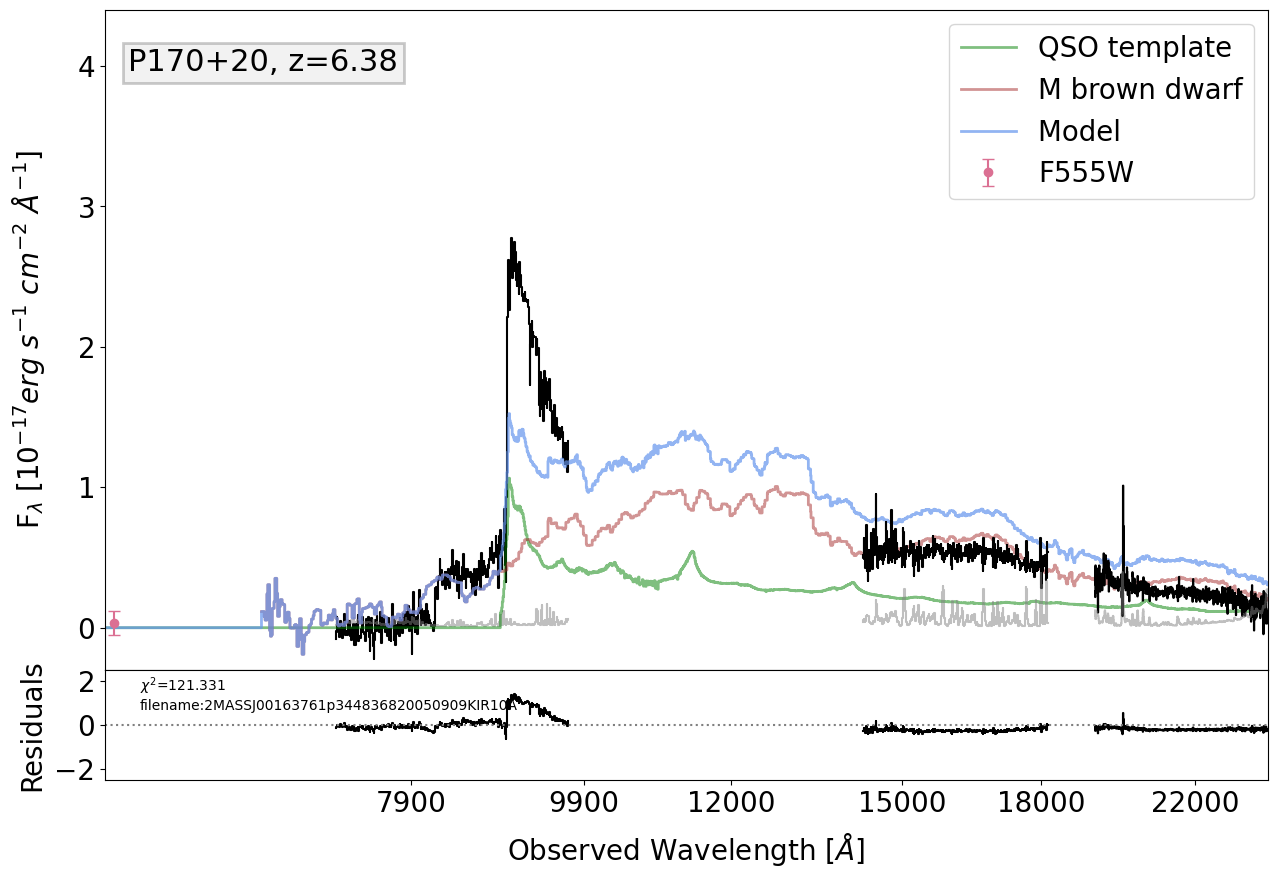

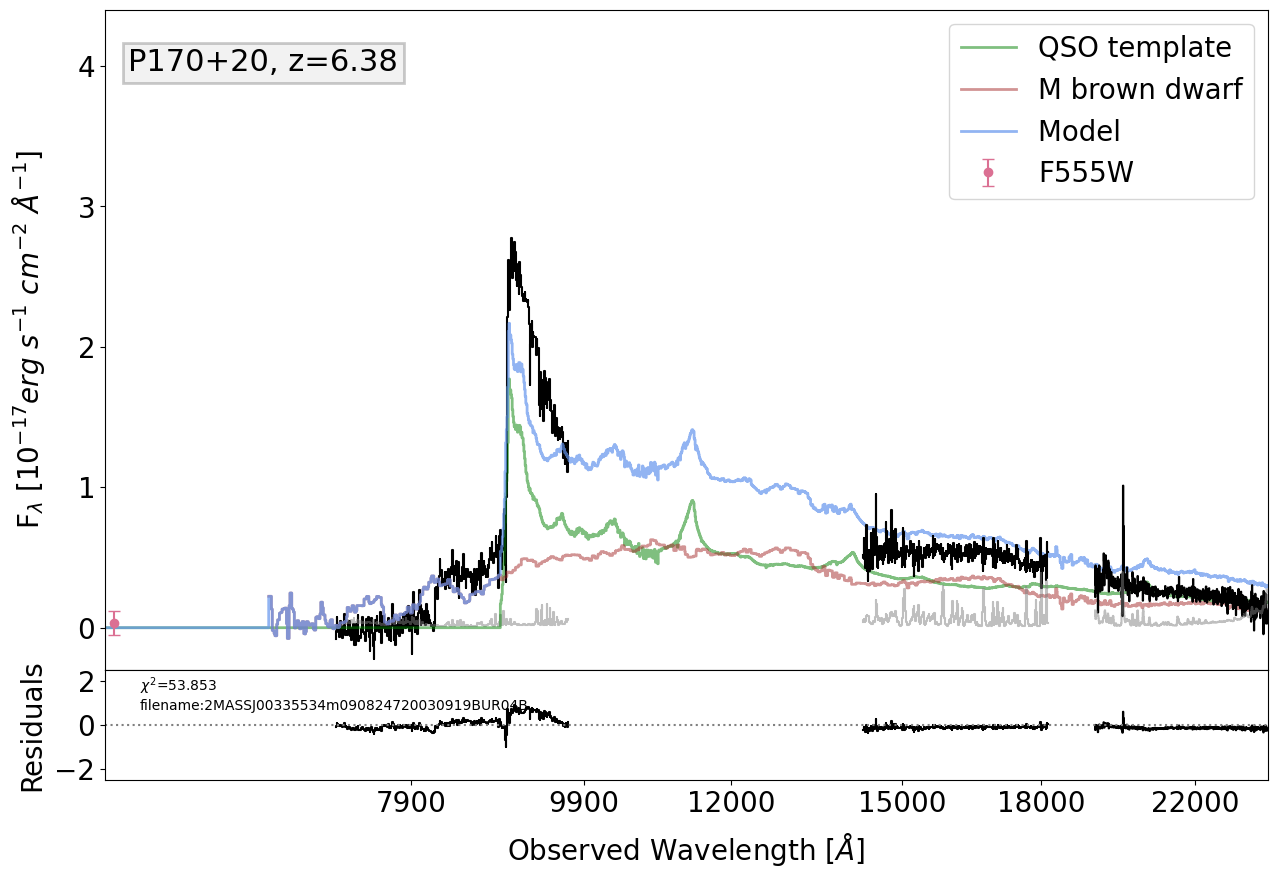

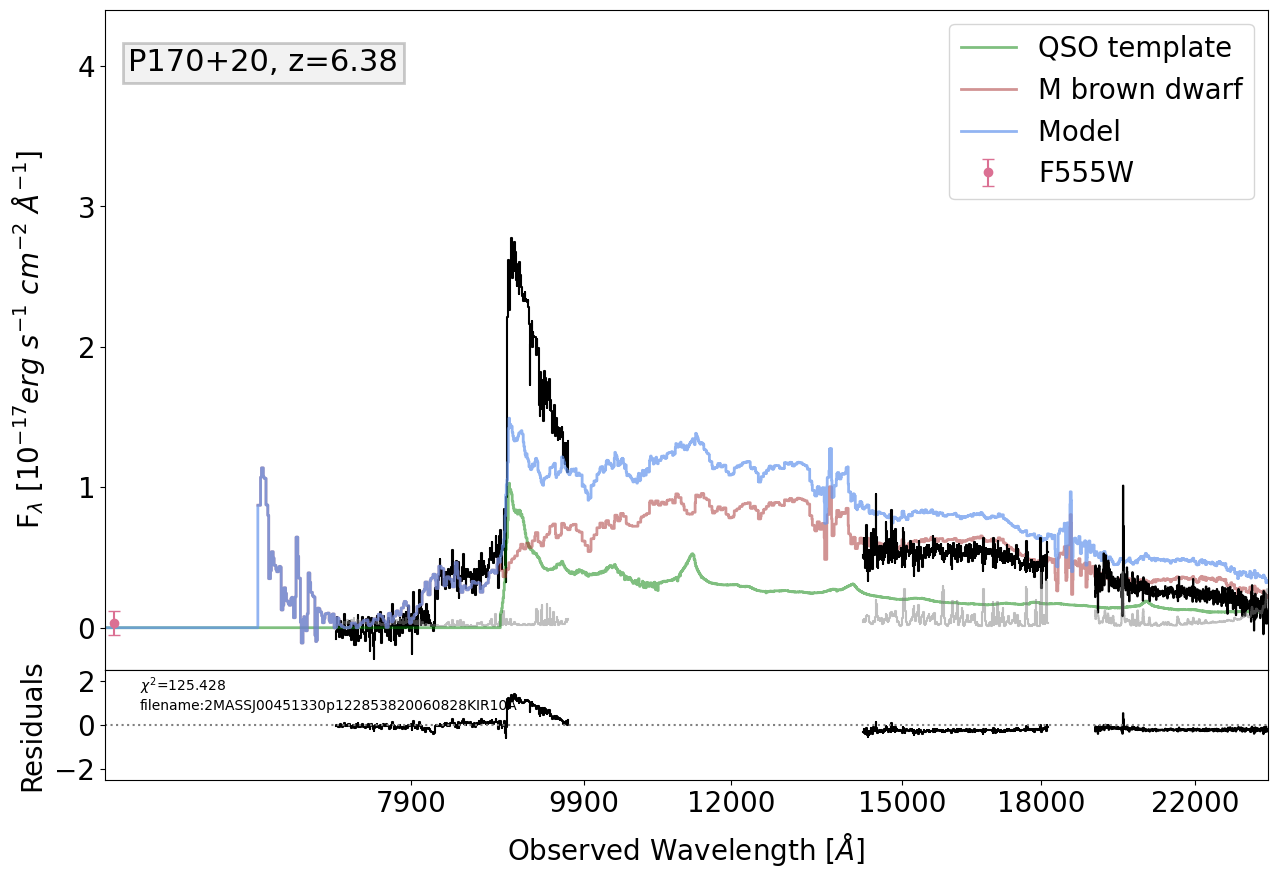

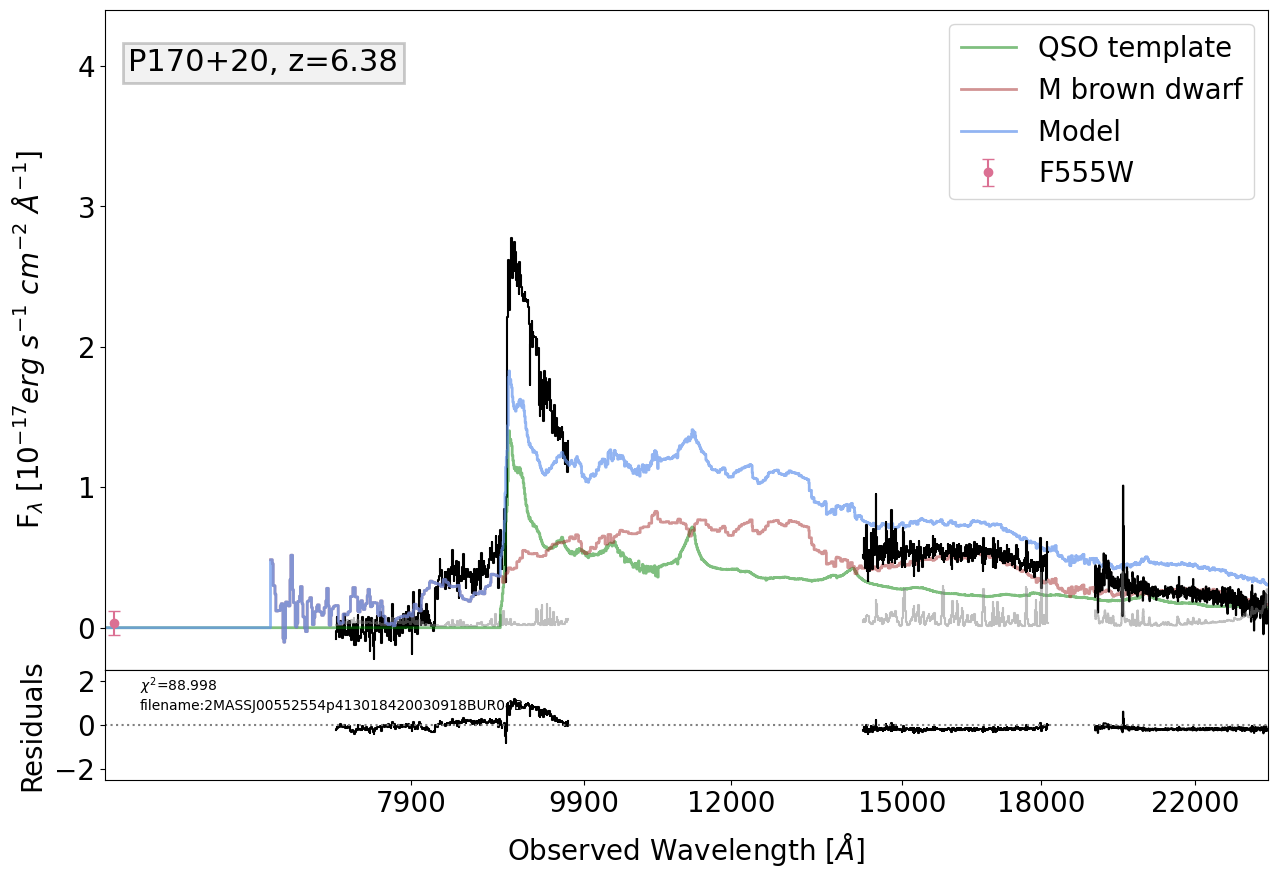

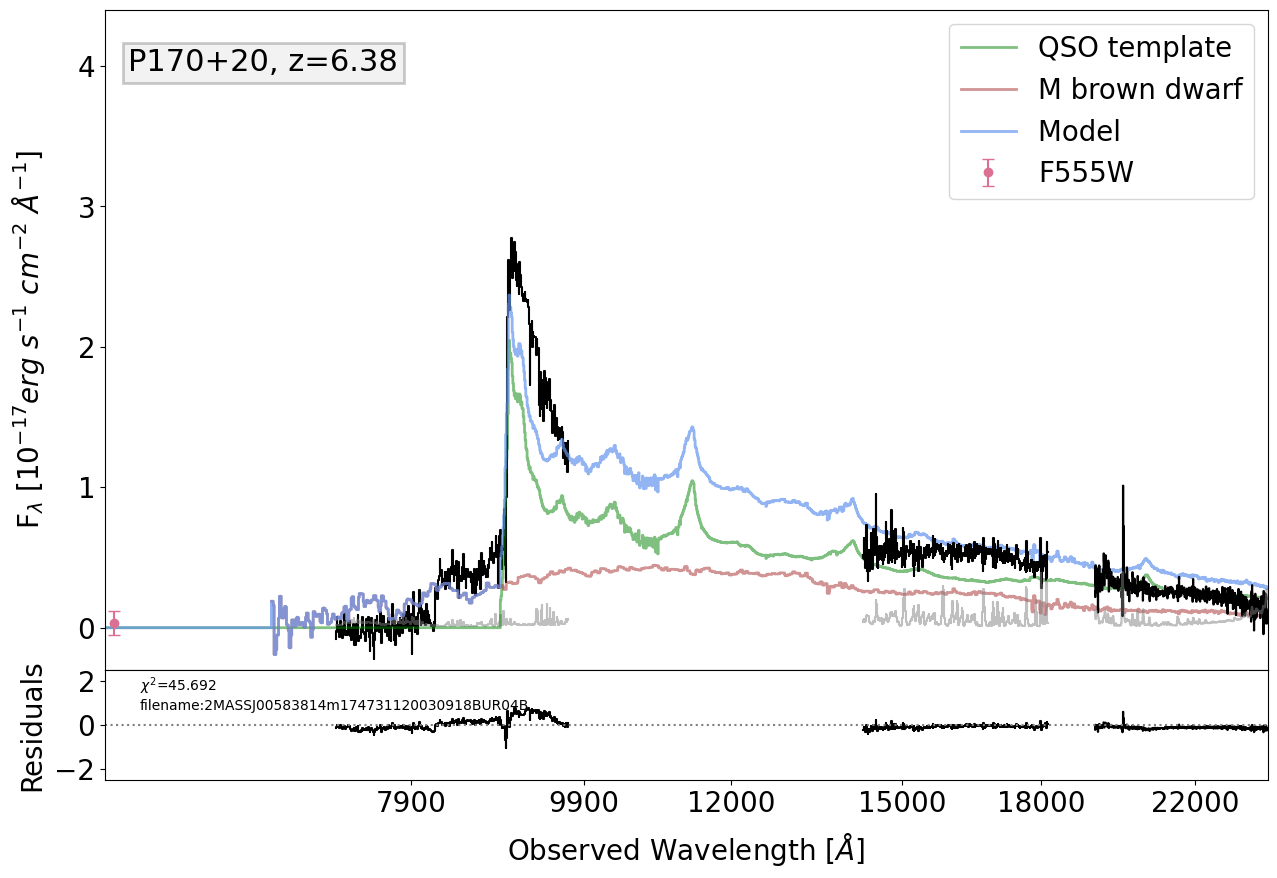

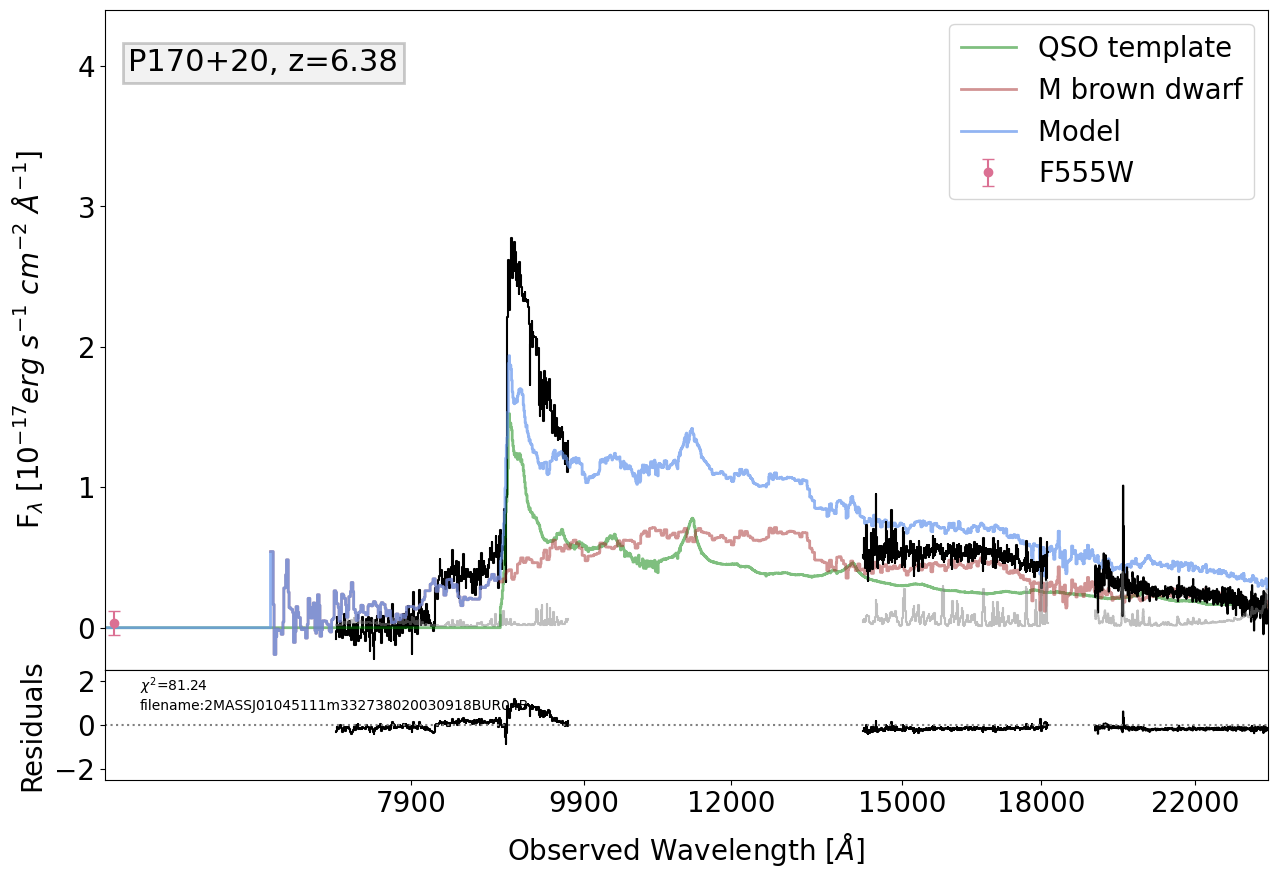

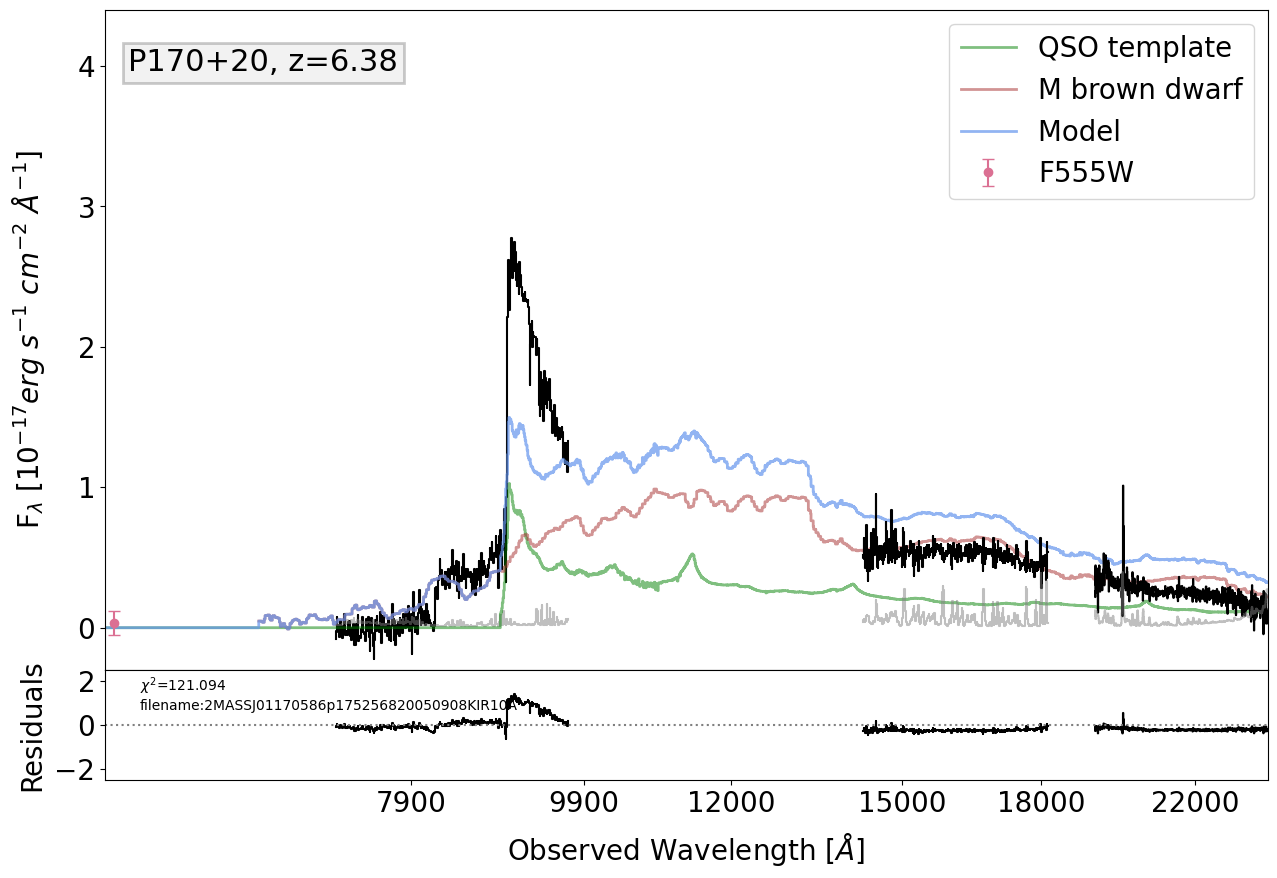

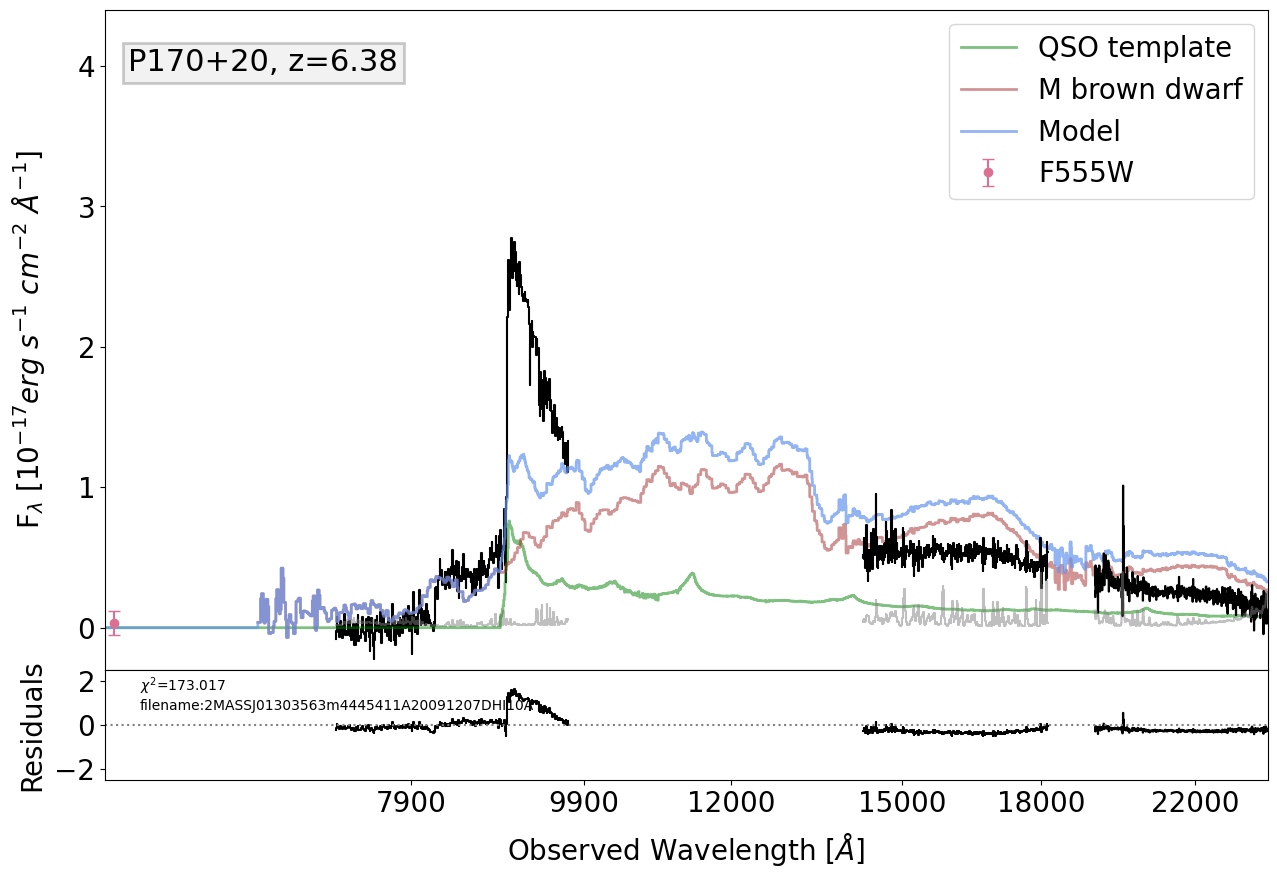

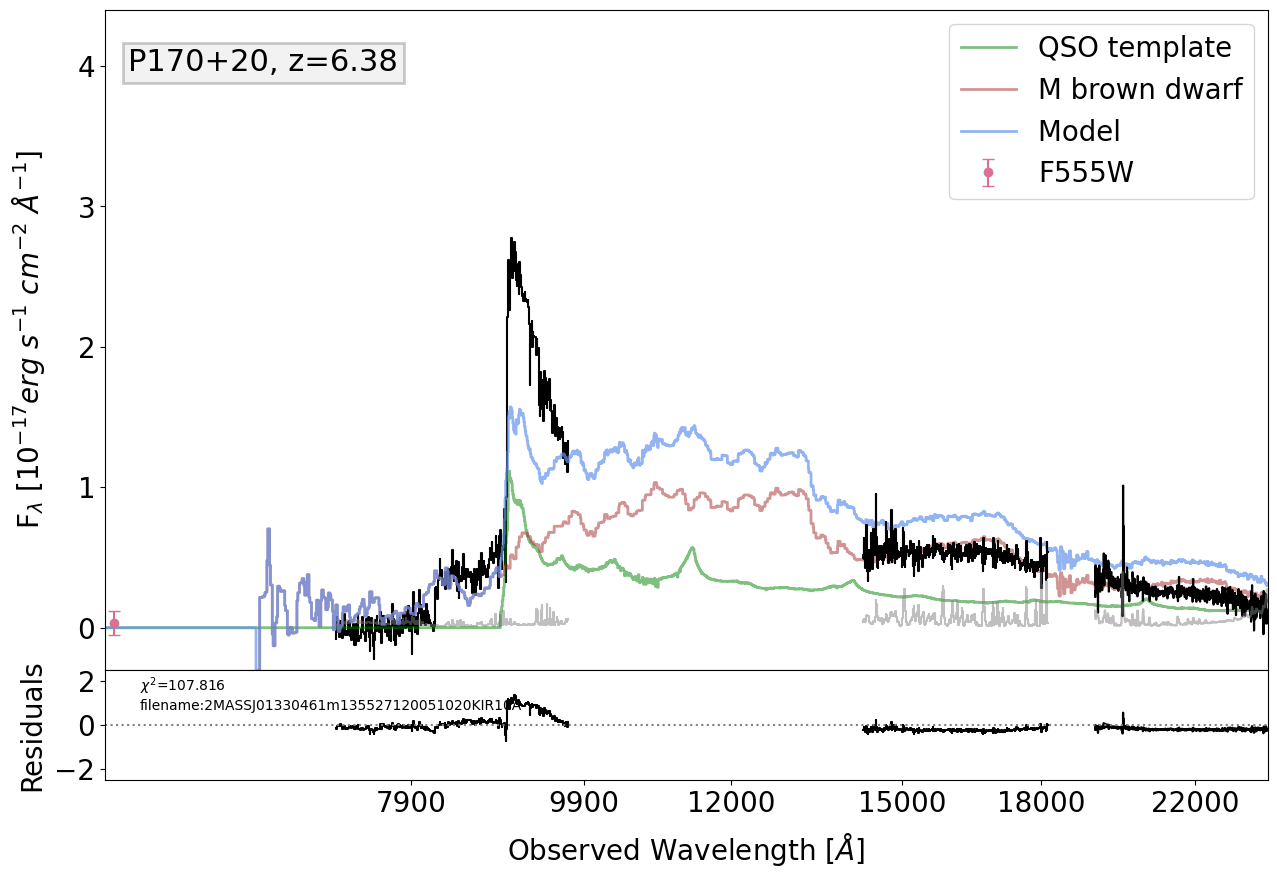

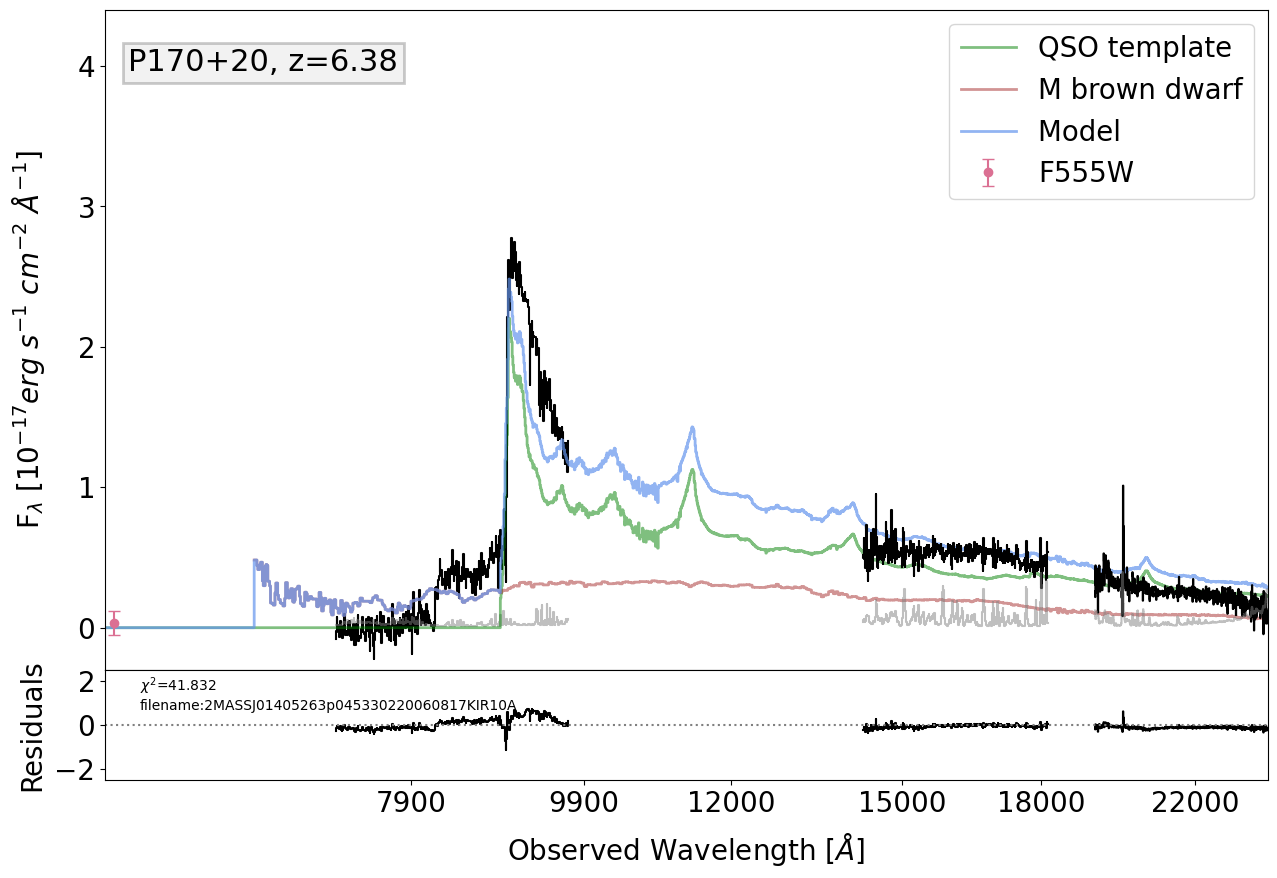

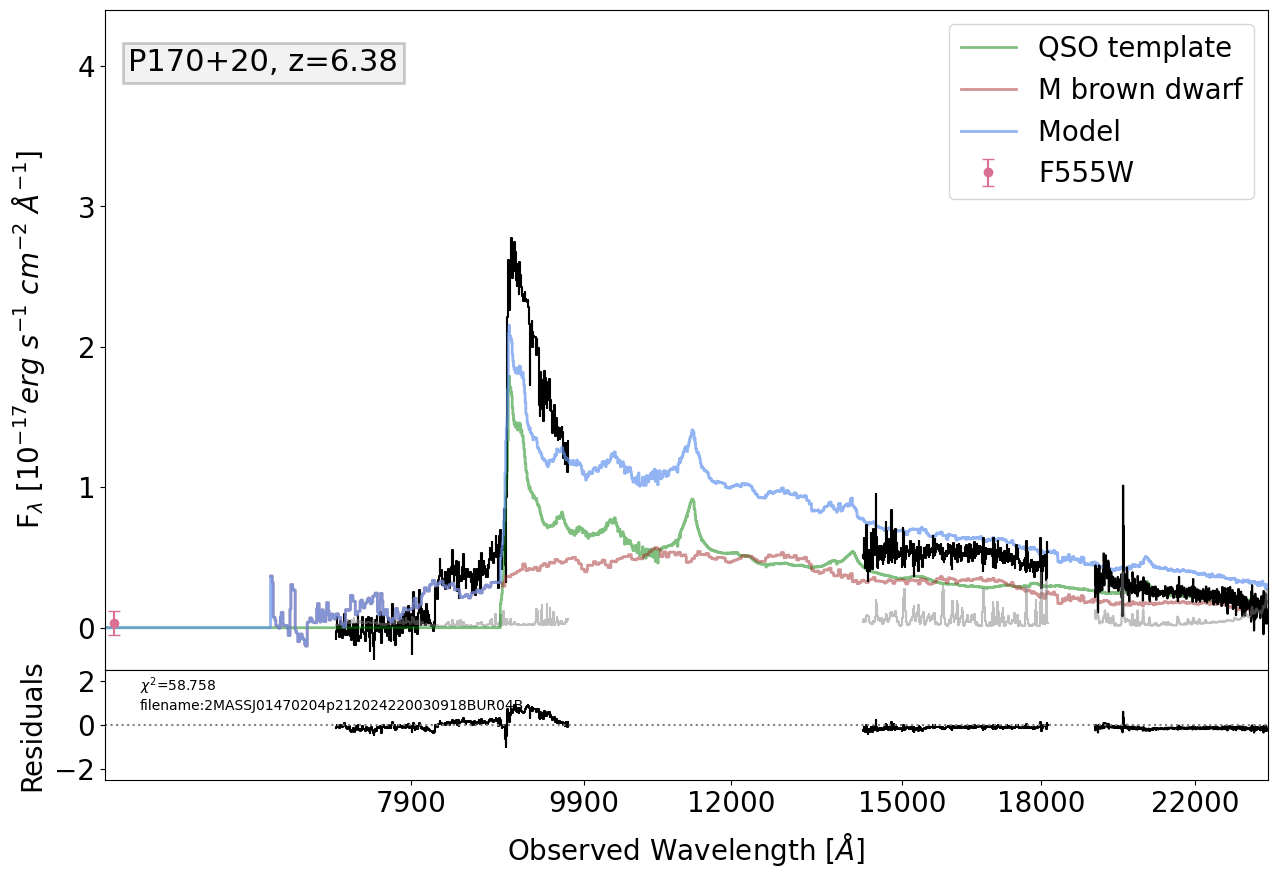

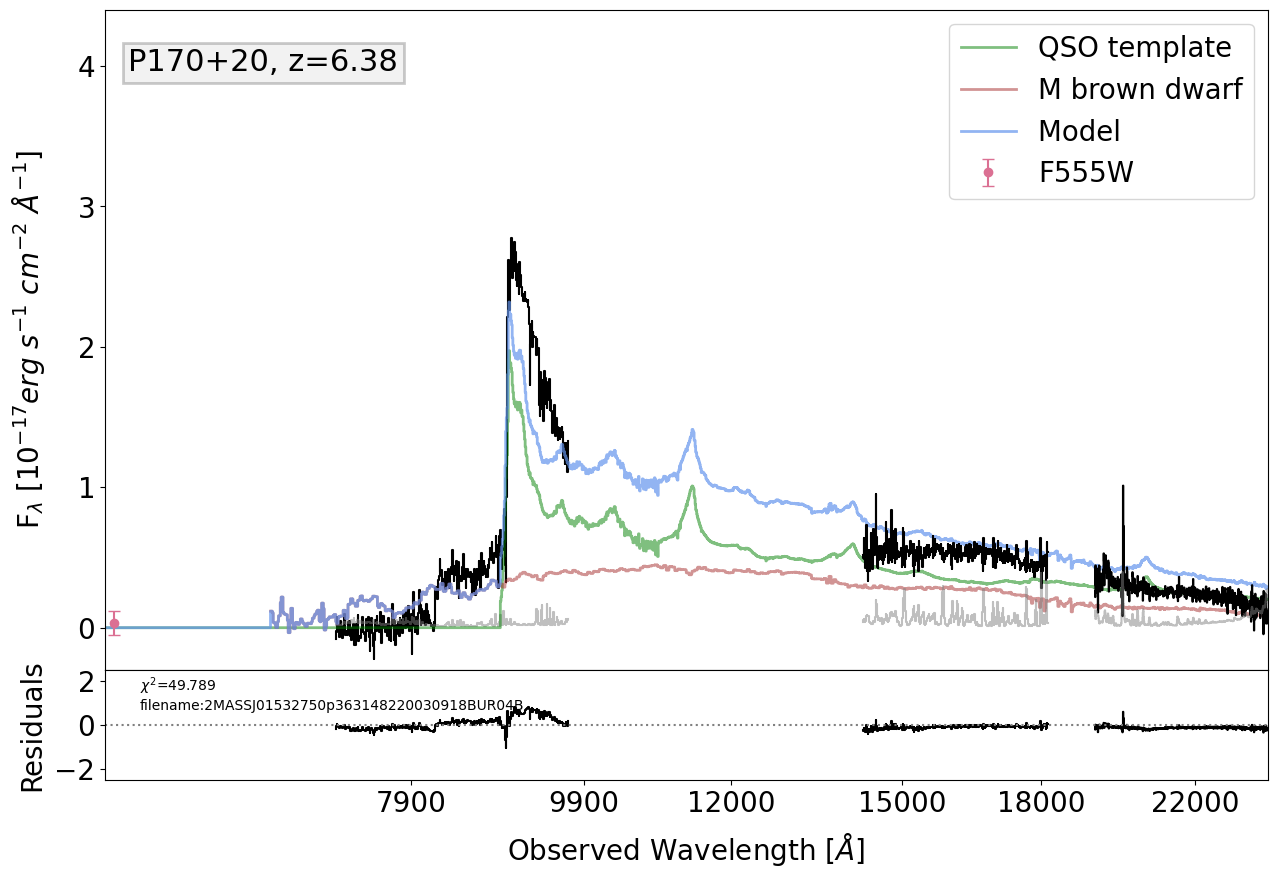

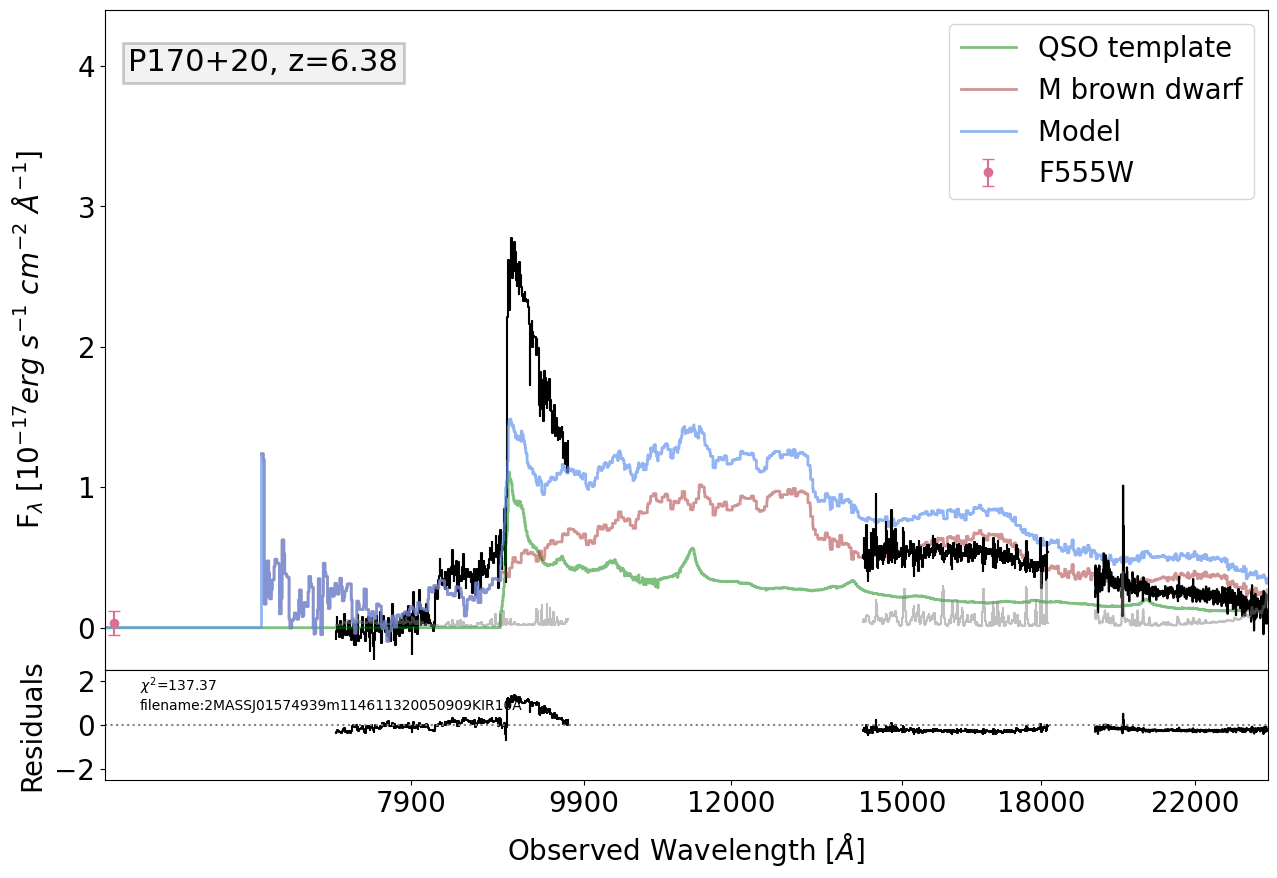

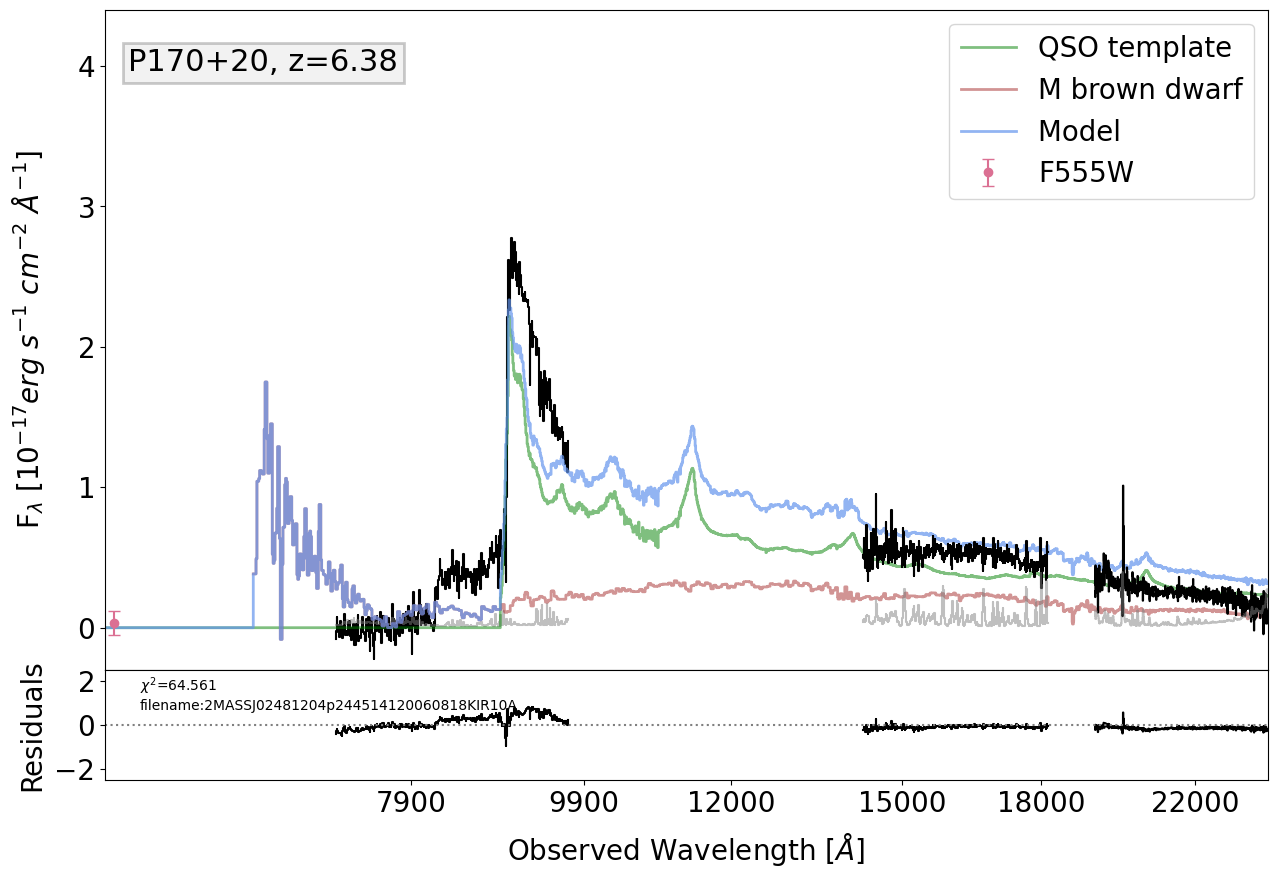

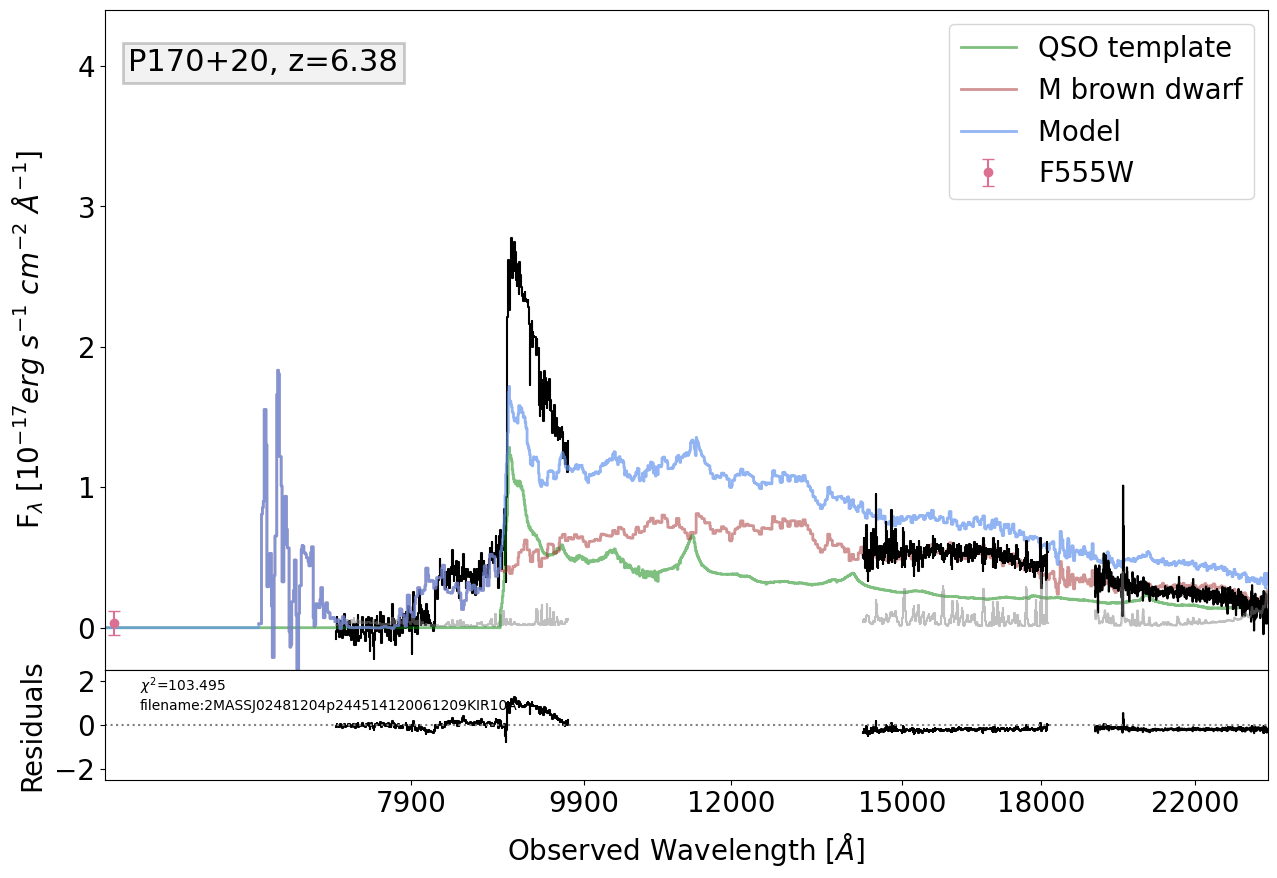

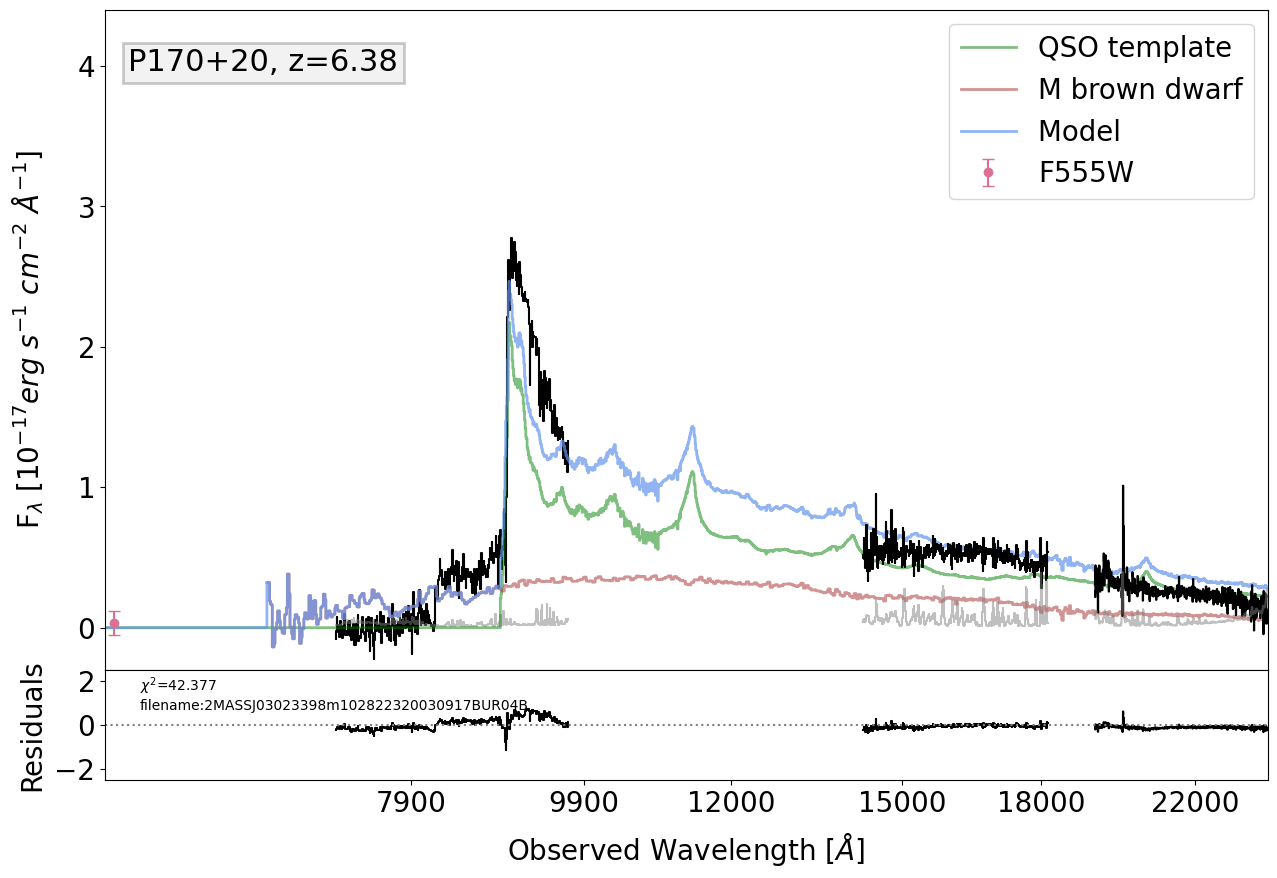

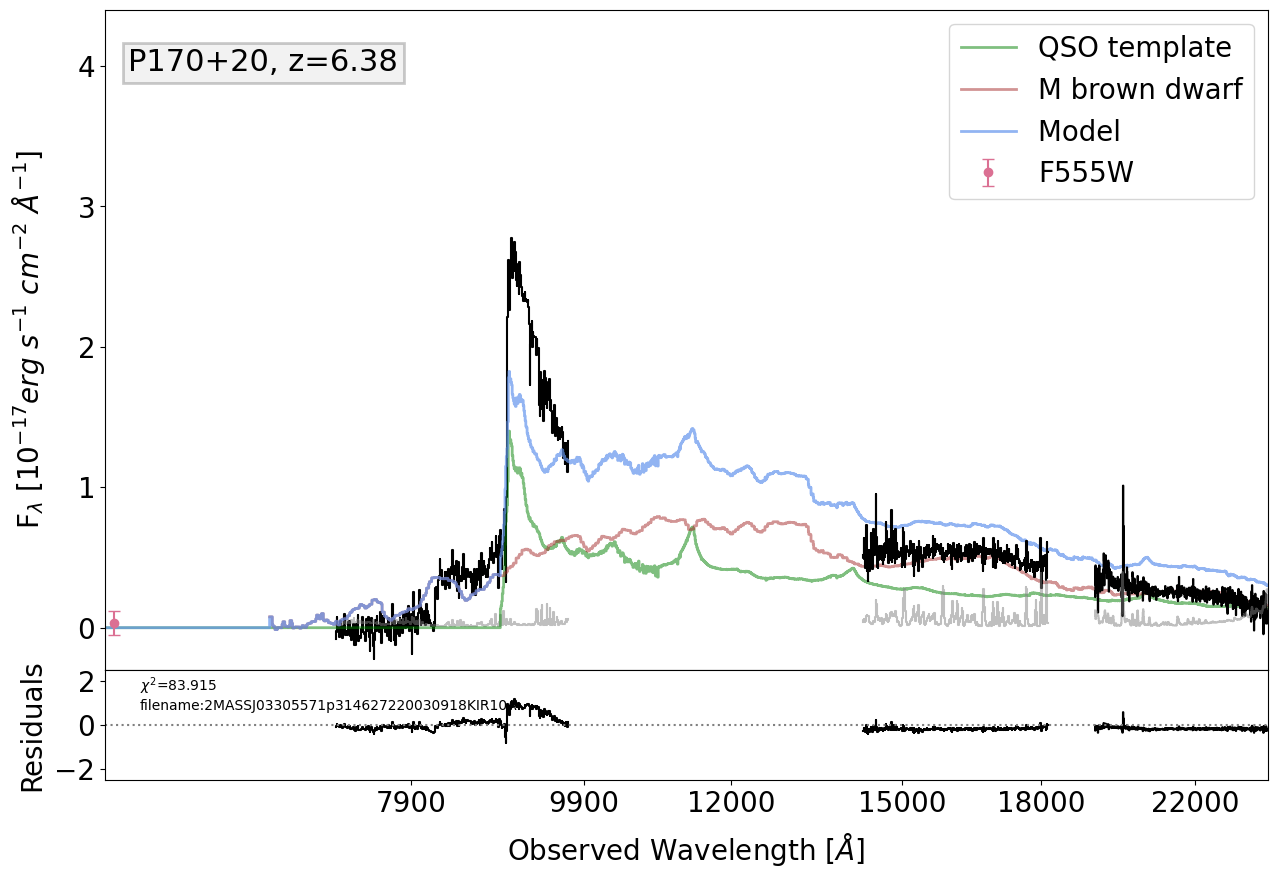

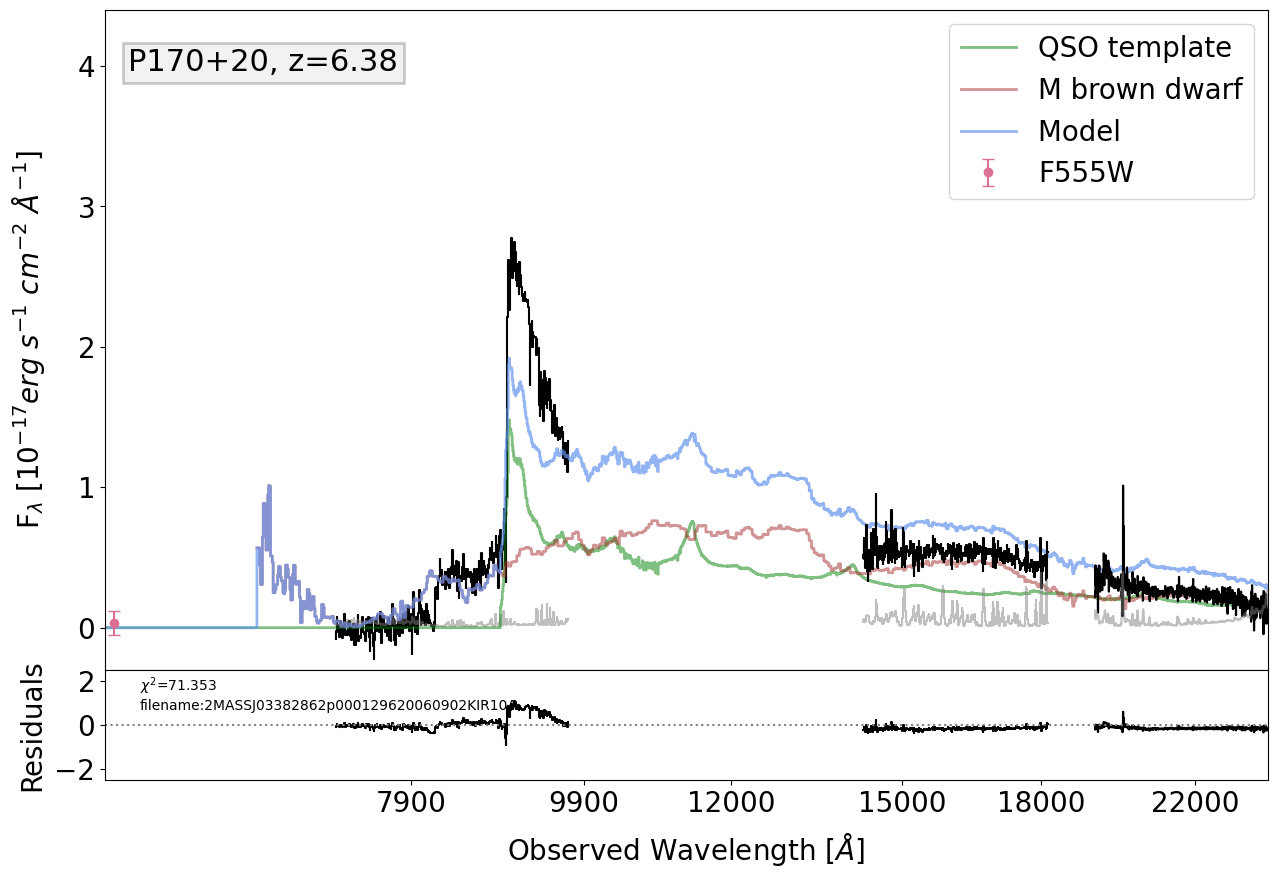

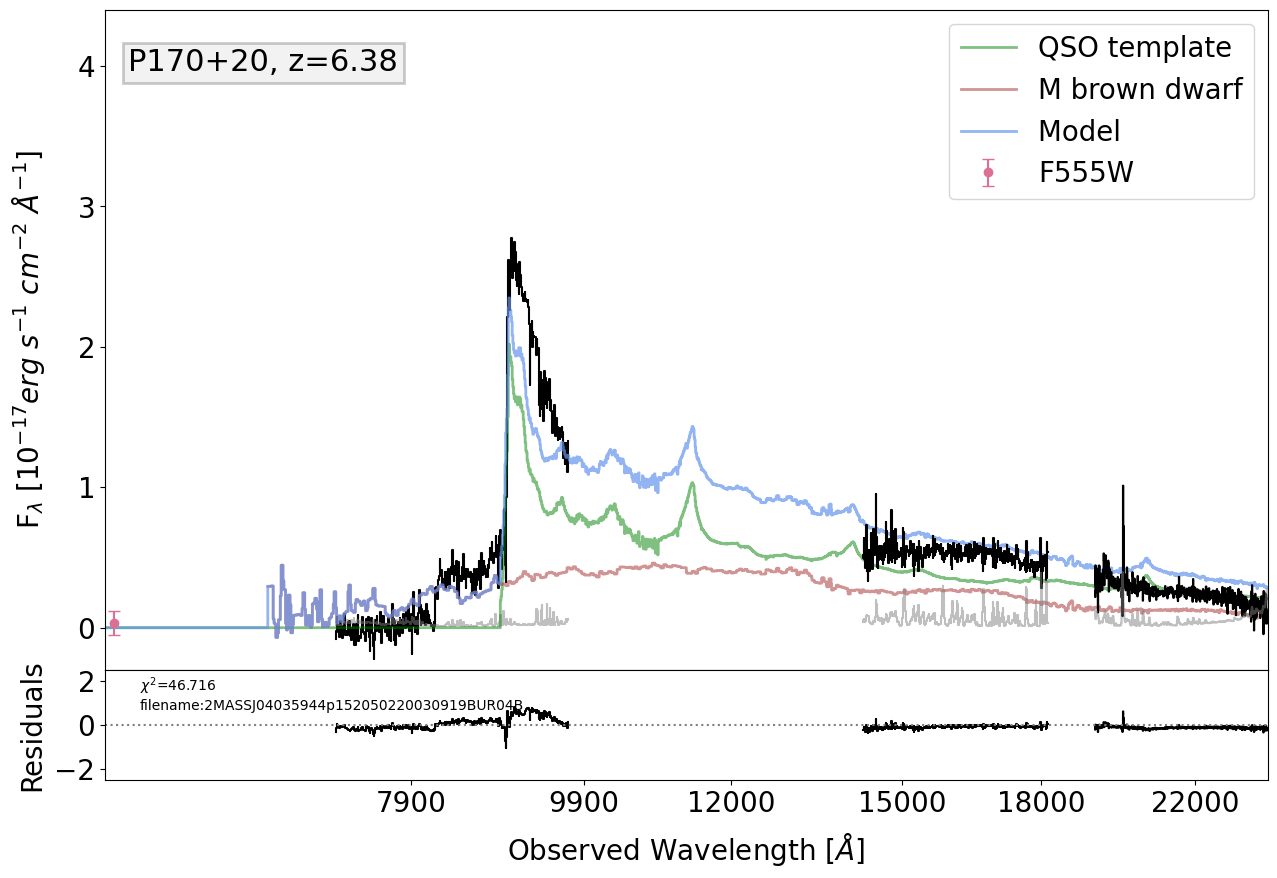

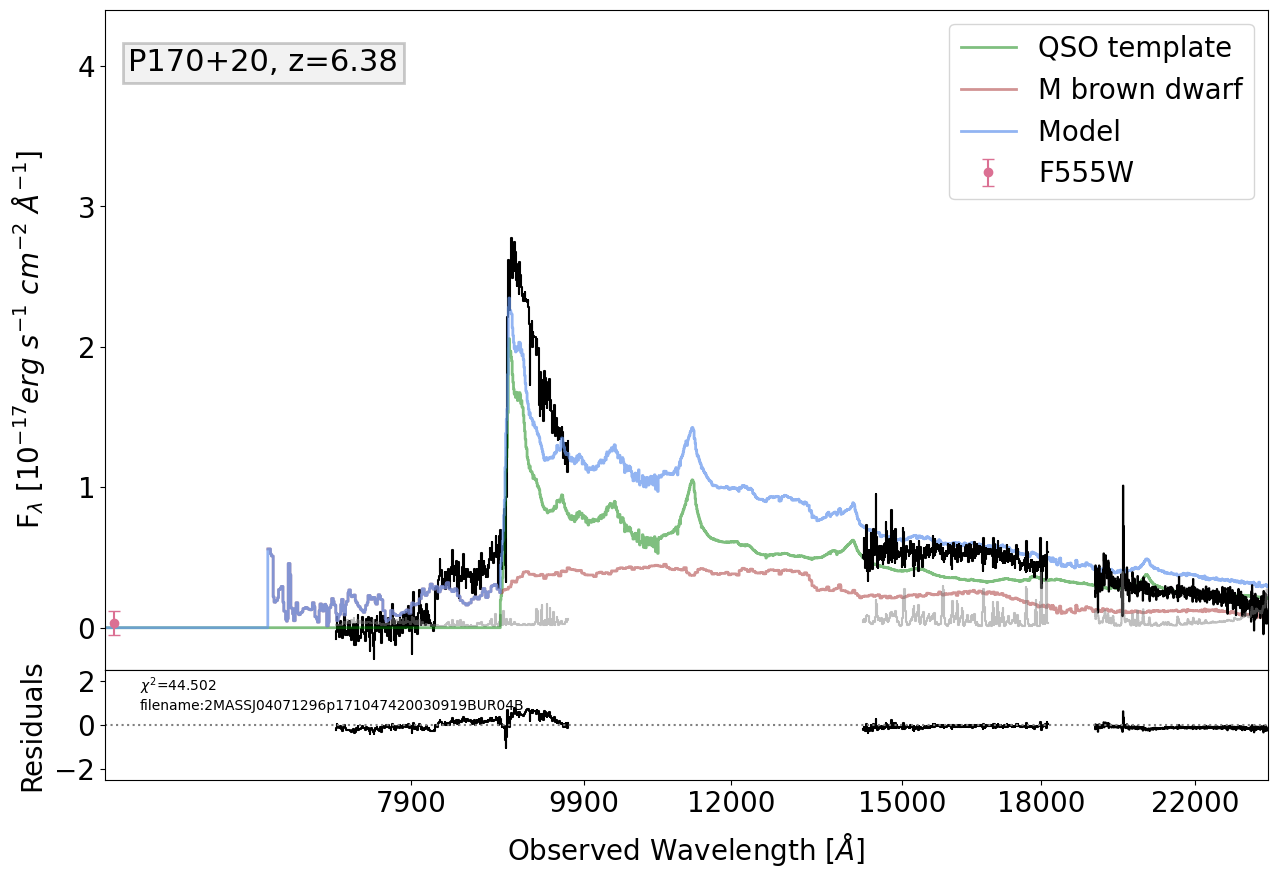

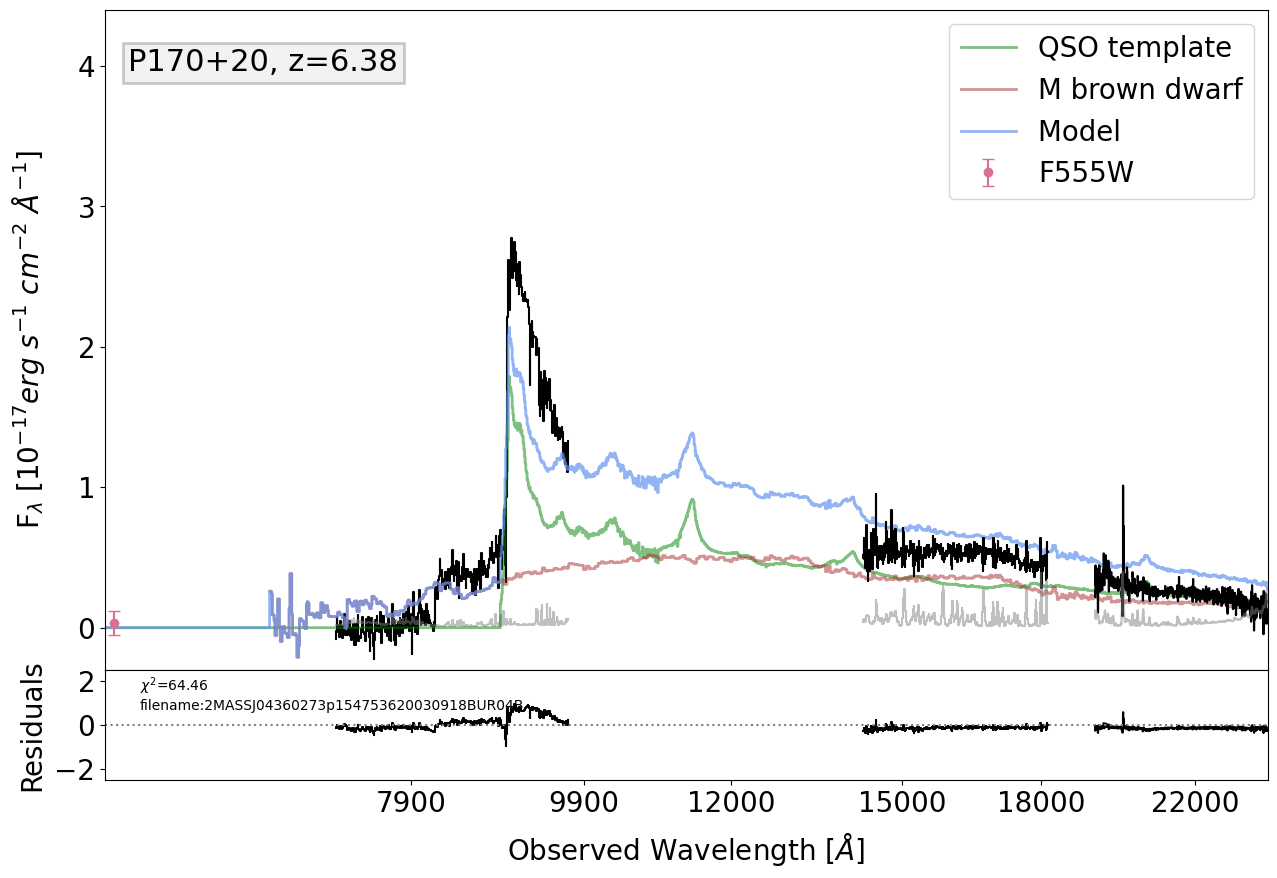

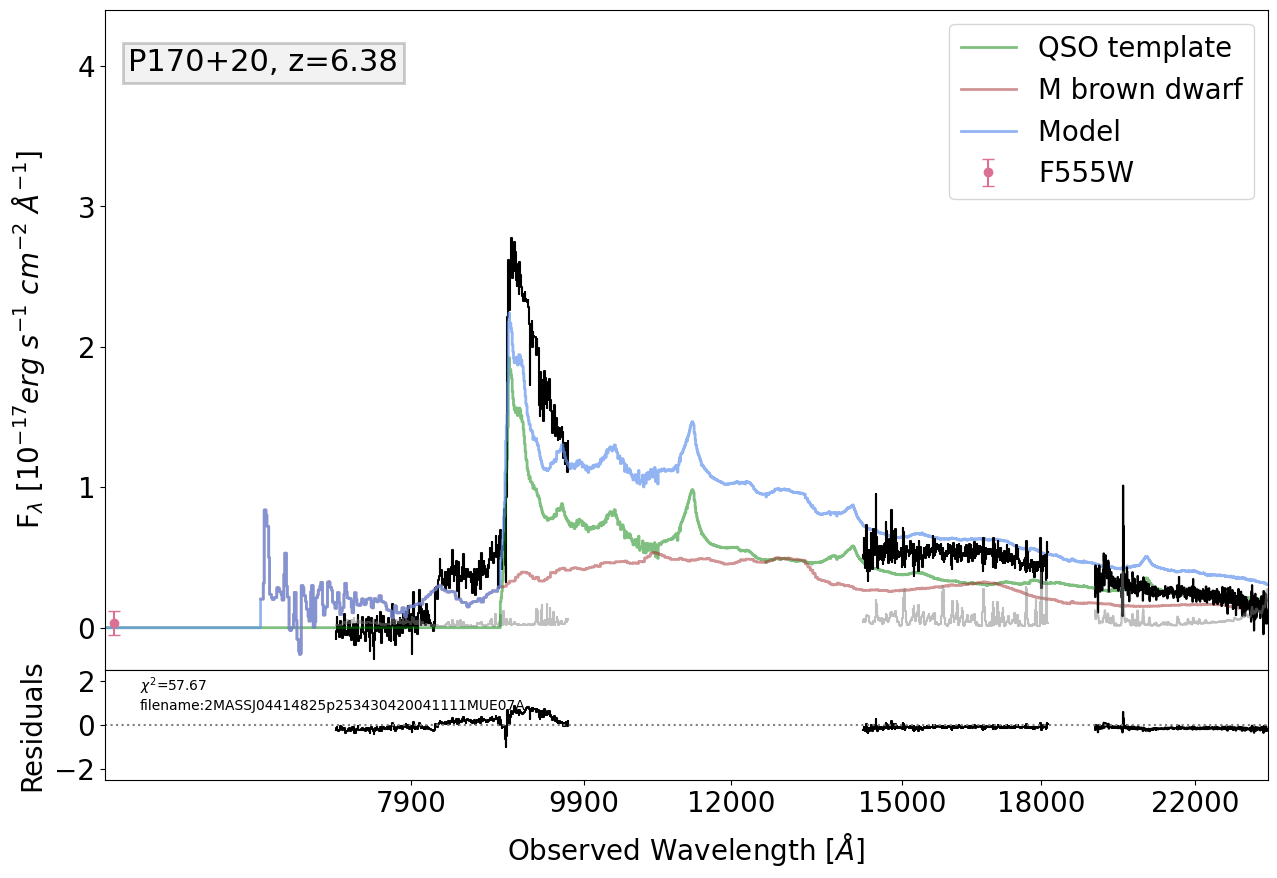

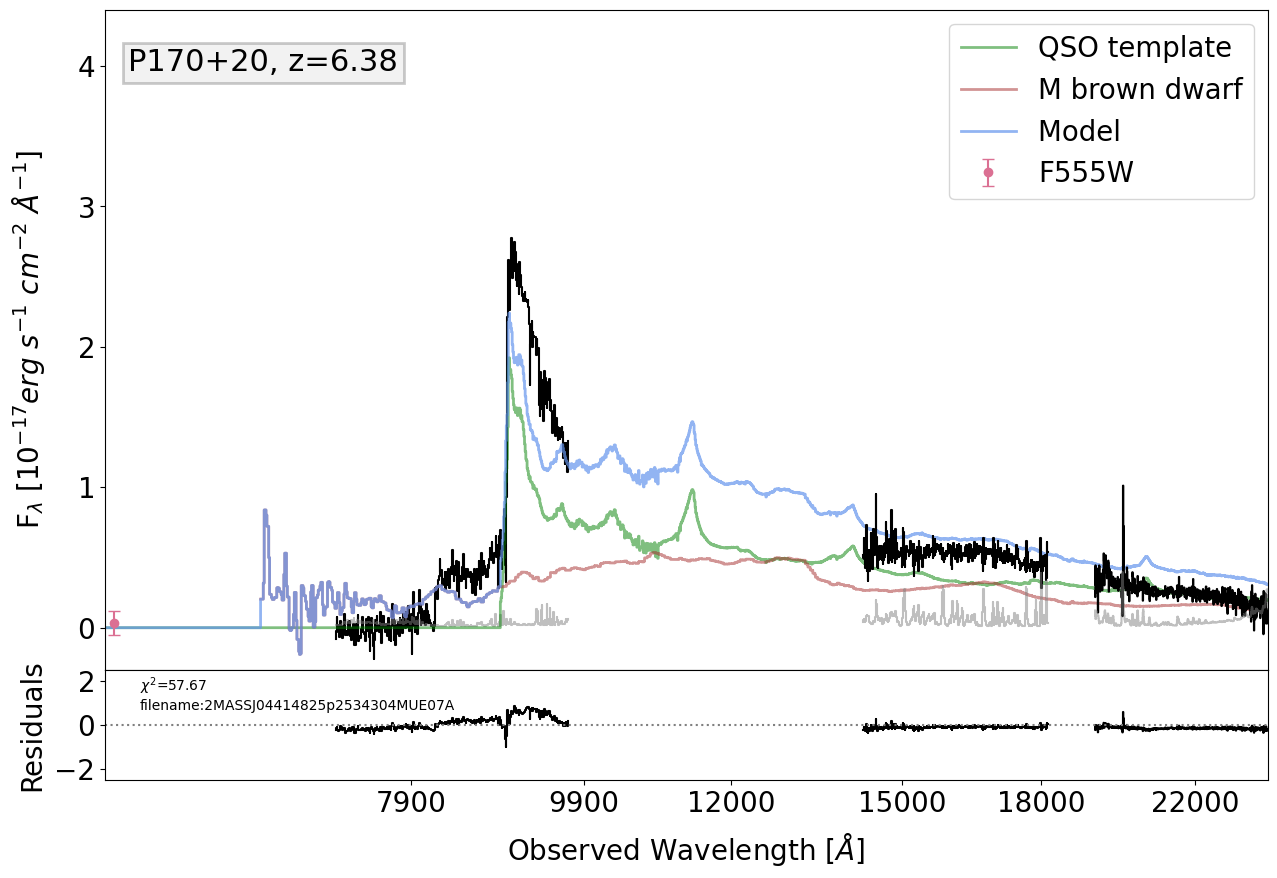

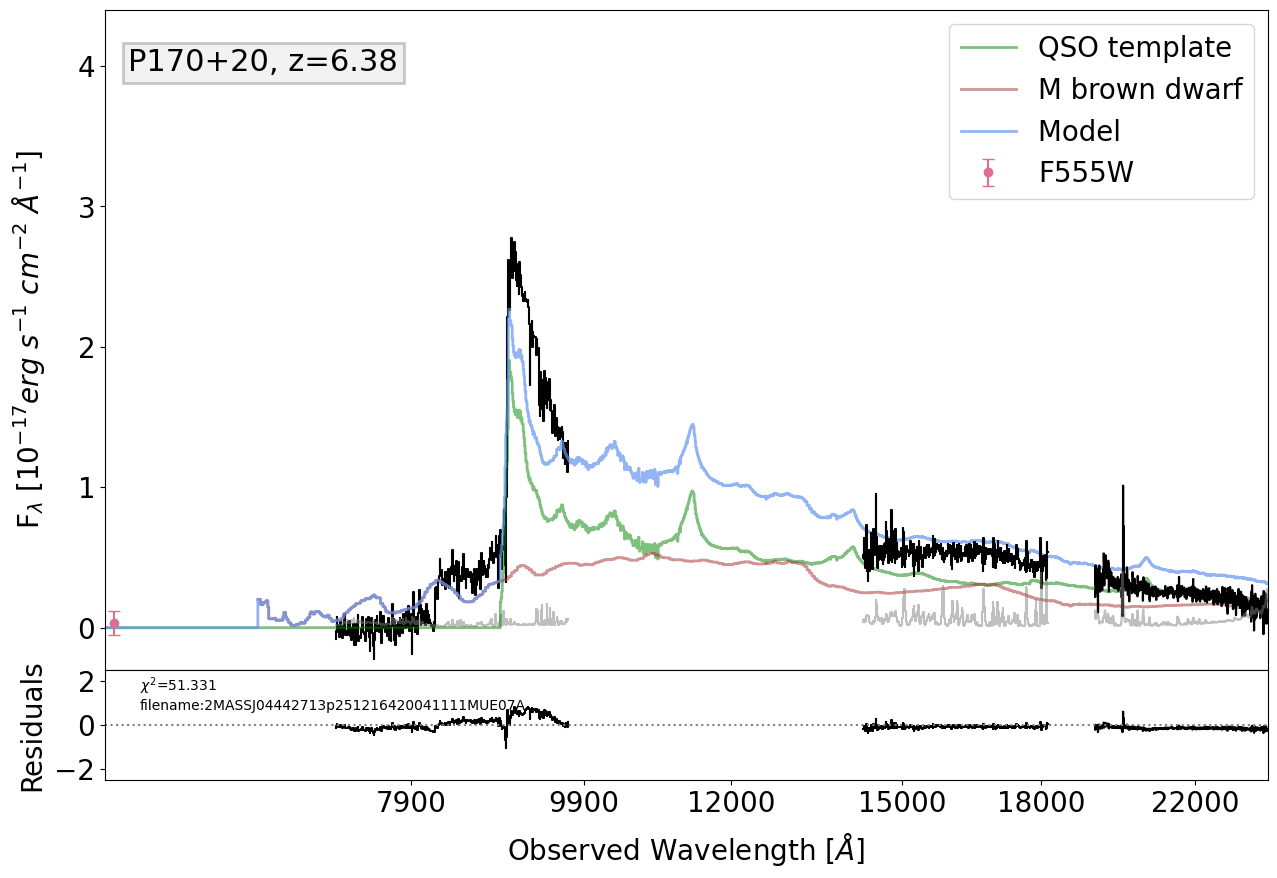

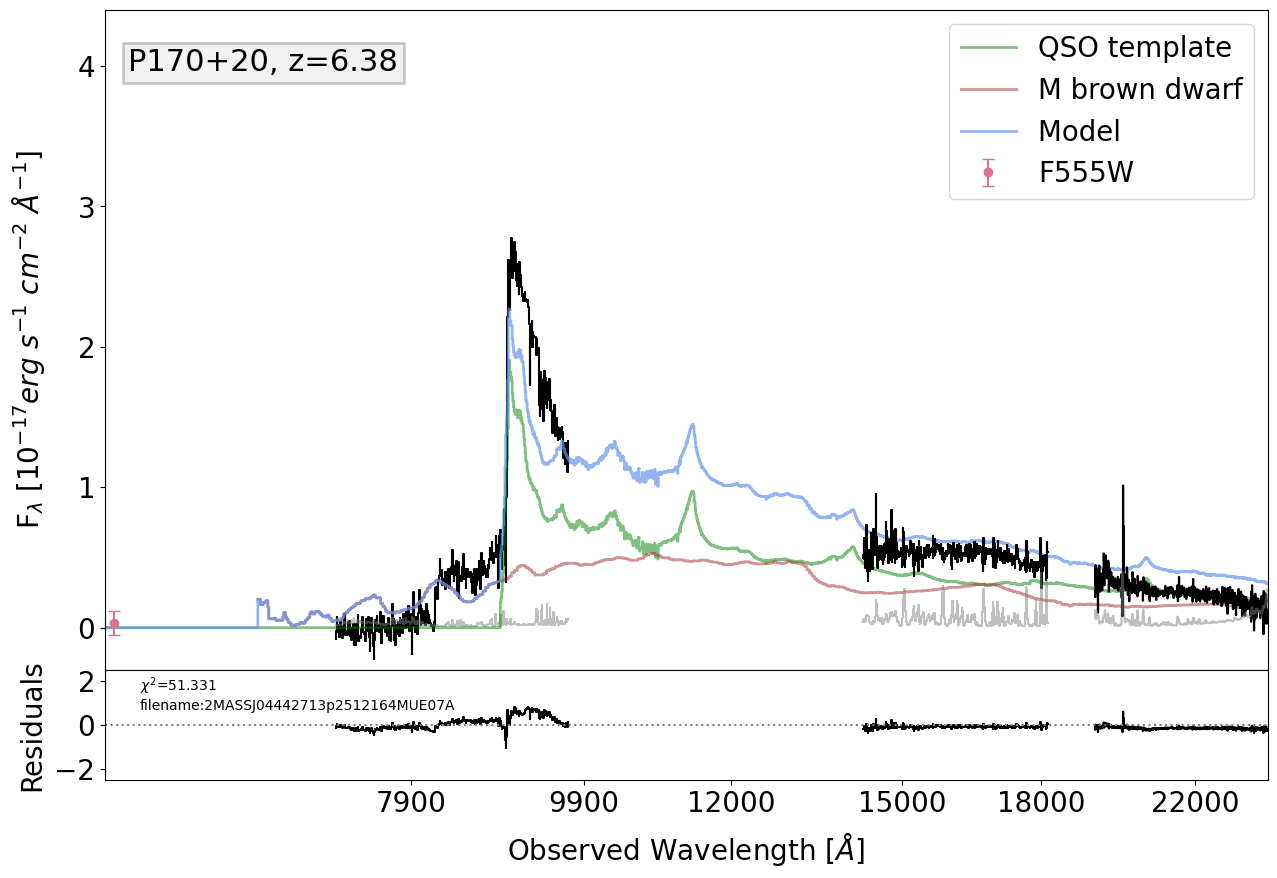

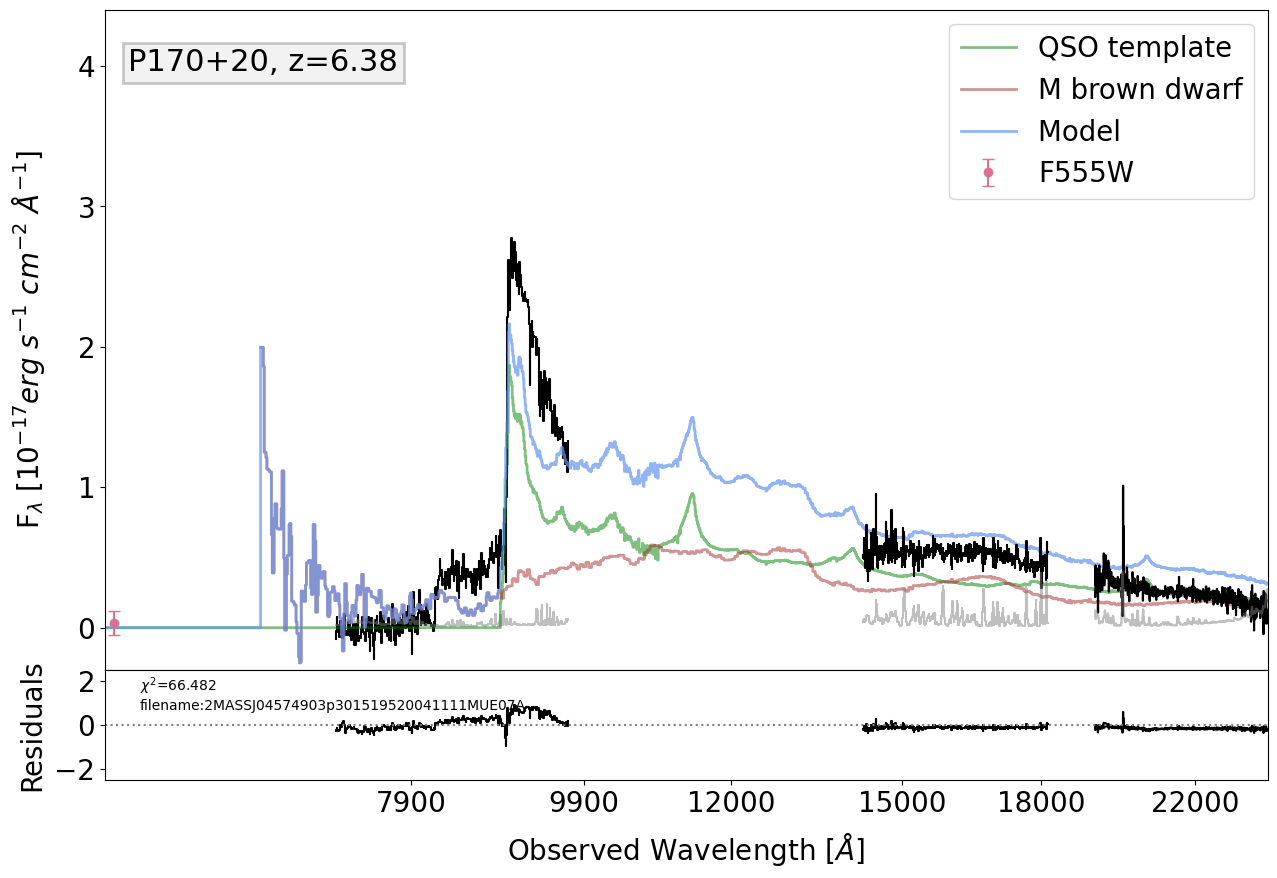

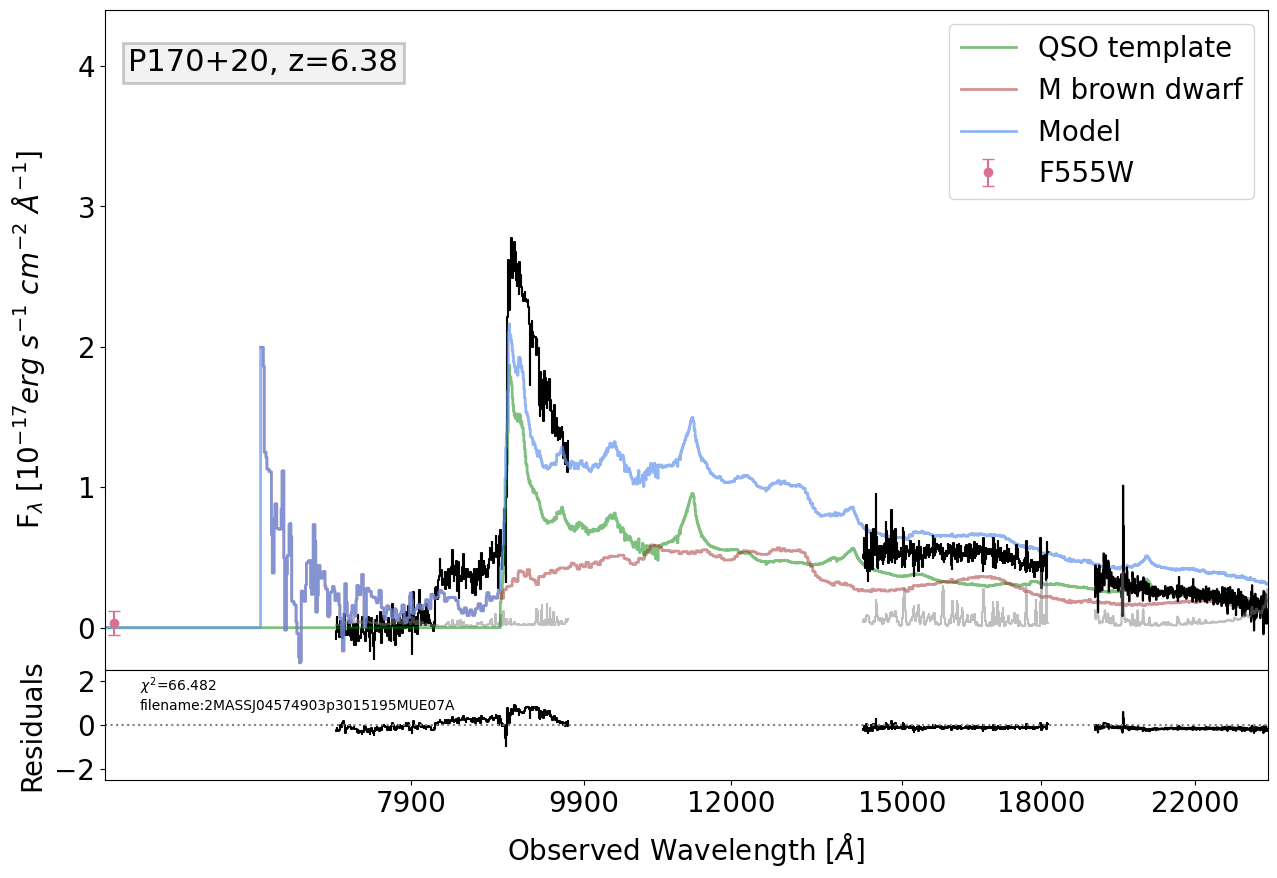

KeyboardInterrupt: 

In [20]:
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import astropy.units as units
from specutils.manipulation import FluxConservingResampler
from specutils import Spectrum1D
import os
from astropy.table import Table
 
def Mdarf_function(filename):
    ruta_completa = os.path.join(ruta, filename)
    
    tabla = Table.read(ruta_completa, format='ascii')
    #tabla = Table.read('/users/aurora.mata/Downloads/MBD/DENISJ1245141m44290720070318LOO07B', format='ascii')
    #Try to do the resample here
    #Include resample data/ pix_size=7.7
    #First Give units to variables with filtered data
    #Total data
    newfluxbd=tabla['col2']*1e-17*units.erg/units.s/units.cm**2/units.AA
    newwavebd=tabla['col1']*1e4*units.AA
    newerrbd=tabla['col3']*1e-17*units.erg/units.s/units.cm**2/units.AA
    
    #convert to Spectrum from specutils 
    input_specbd=Spectrum1D(spectral_axis=newwavebd,flux=newfluxbd) 
    input_spec_errbd=Spectrum1D(spectral_axis=newwavebd,flux=newerrbd)
    
    #Resample here
    fluxconbd = FluxConservingResampler()
    new_spec_fluxconbd = fluxconbd(input_specbd, new_disp_grid)
    #new_spec_fluxcon_errbd = fluxconbd(input_spec_errbd, new_disp_grid)
    maskcurve=(originaldata_wave>969.47*(z+1))&(originaldata_wave<1210*(1+z))
    bdspectra=new_spec_fluxconbd.flux.value[maskcurve]
    
    def databrownd(x,c):
        f = c*bdspectra
        return f


    popt,pcov=curve_fit(databrownd,xdata=originaldata_wave[maskcurve],ydata=originaldata_flux[maskcurve],p0=[2.2])
    factorcbd=popt[0]
    
    # #Average bd
    # mask_a3=(originaldata_wave>16200)&(originaldata_wave<16400) 
    # mask_bt=(16200<new_spec_fluxconbd.spectral_axis.value)&(16400>new_spec_fluxconbd.spectral_axis.value)
    
    # av_qso3=np.mean(residual3[mask_a3])
    # av_bdm=np.mean(new_spec_fluxconbd.flux.value[mask_bt])
    # factorbdm3=av_qso3/av_bdm

    #####################
    maskresqso1=(originaldata_wave>1215*(1+z))&(originaldata_wave<1330*(1+z))
    maskresqso2=(originaldata_wave>1940.29*(z+1))&(originaldata_wave<2469.47*(z+1))
    maskresqso3=(originaldata_wave>2618.72*(z+1))&(originaldata_wave<3283.58*(z+1))
    maskresqso=maskresqso1|maskresqso2|maskresqso3
    bdscale=new_spec_fluxconbd.flux.value*factorcbd
    residualbddata=originaldata_flux-bdscale
    residualbddatac=tabc['FLUX'][maskresqso]

    def residual(x,c):
        f = c*residualbddatac
        return f
    
    
    #mask_no_nan = ~np.isnan(tabc['FLUX'])
    popt2,pcov2=curve_fit(residual,xdata=originaldata_wave[maskresqso],ydata=residualbddata[maskresqso],p0=[4.2])
    factorcresqso=popt2[0]
    
    #print('factor qso', factorcresqso)
    # tabc = astropy.table.Table()
    # tabc['WAVE']= np.append(composite_wave[maskpr],wl[maskcs2])
    # tabc['FLUX']= np.append(composite_flux[maskpr],weighted_mean[maskcs2]*factorcresqso)
    ###########


    #sumspectra my model
    browndspectra=new_spec_fluxconbd.flux.value*factorcbd#*factorbdm3
    sumspectra=np.nan_to_num(browndspectra+(tabc['FLUX']*factorcresqso))#d
    substraction=originaldata_flux-sumspectra
    originaldata_err=new_spec_fluxcon_err.flux.value
    
    
    mask1= (originaldata_wave>7156.777)&(originaldata_wave<9710)
    mask2= (originaldata_wave>14250)&(originaldata_wave<18150) 
    mask3= (originaldata_wave>19300)&(originaldata_wave<24181.477) 


    #Calculation of chi square
    maskf= mask1 | mask2 | mask3
    chisquare=np.sum((substraction[maskf])**2/((originaldata_err[maskf])**2))
    reducedchi=chisquare/(len(originaldata_flux[maskf])-2)
    #chisquare=np.sum(substraction[maskf])**2/np.std(originaldata_flux[maskf])**2
    #reducedchi=chisquare/len(originaldata_flux[maskf])-2
    reducedchi
    #print(r'$\chi^2$='+str(np.round(reducedchi,3)))


    #All plotting from here
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.5])
    
    ax1 = fig.add_subplot(gs[0])
    
    #Primer parte
    ax1.step(originaldata_wave[mask1],originaldata_flux[mask1],color='black')
    ax1.step(originaldata_wave[mask1], originaldata_err[mask1] ,color='grey',alpha=0.5)
    
    ax1.step(originaldata_wave,tabc['FLUX']*factorcresqso,label='QSO template',alpha=0.5,color='green',linewidth=2)
    ax1.step(originaldata_wave,browndspectra,label='M brown dwarf',alpha=0.5,color='brown',linewidth=2)
    ax1.step(originaldata_wave,sumspectra,label='Model ',color='cornflowerblue',alpha=0.7,linewidth=2)
    
    #Segunda parte
    ax1.step(originaldata_wave[mask2],originaldata_flux[mask2],color='black')
    ax1.step(originaldata_wave[mask2], originaldata_err[mask2] ,color='grey',alpha=0.5)
    
    #ax1.step(originaldata_wave[mask2],tabc['FLUX'][mask2]*factorcresqso,alpha=0.5,color='green',linewidth=2)
    #ax1.step(originaldata_wave[mask2],browndspectra[mask2],alpha=0.5,color='brown',linewidth=2)
    #ax1.step(originaldata_wave[mask2],sumspectra[mask2],alpha=0.7,color='cornflowerblue',linewidth=2)
    
    #Tercera parte
    ax1.step(originaldata_wave[mask3], originaldata_flux[mask3],color='black')
    ax1.step(originaldata_wave[mask3], originaldata_err[mask3] ,color='grey',alpha=0.5)
    
    #ax1.step(originaldata_wave[mask3],tabc['FLUX'][mask3]*factorcresqso,alpha=0.5,color='green',linewidth=2)
    #ax1.step(originaldata_wave[mask3],browndspectra[mask3],alpha=0.5,color='brown',linewidth=2)
    #ax1.step(originaldata_wave[mask3],sumspectra[mask3],alpha=0.7,color='cornflowerblue',linewidth=2)
    
    #ax1.legend(fontsize=19.9,loc='upper right')
    ax1.tick_params(labelbottom=False) 
    bbox=dict(facecolor='silver',   # Color de fondo
                  edgecolor='black',          # Borde
                  linewidth=2,
                  alpha=0.2)
    ax1.text(0.02,0.92,'P170+20, z=6.38',va='center', rotation='horizontal',fontsize=22,bbox=bbox,transform=ax1.transAxes)
    ax1.set_ylabel('F$_{\lambda}$ $[10^{-17} erg~s^{-1}~cm^{-2}~\AA^{-1}]$',fontsize=20,labelpad=22)
    ax1.yaxis.set_tick_params(labelsize=20)
    #ax1.set_ylabel('$f_{\lambda}$ $(10^{-17} erg~s^{-1}~cm^{-2}~\AA^{-1})$',fontsize=16)
    ax1.set_xlim(5300,24181.477)#(7156.777,24181.477)
    ax1.set_ylim(-0.3e-17,4.4e-17)
    plt.errorbar(x=5361, y=3.2e-19, yerr=0.85e-18, fmt='o', capsize=4,label='F555W',color='palevioletred')

    #ax1.plot(originaldata_wave,  residual3,label='Substraction data-templates' )

 
    
    
    
    #Lower plot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.step(originaldata_wave[mask1],substraction[mask1],color='black')
    ax2.step(originaldata_wave[mask2],substraction[mask2],color='black')
    ax2.step(originaldata_wave[mask3],substraction[mask3],color='black')
    ax2.axhline(y=0,color='grey',linestyle='dotted')
    #ax2.plot([7156.777, 9736.701], [0, 0], color='grey', linestyle='dotted')
    #ax2.plot([14250, 18150], [0, 0], color='grey', linestyle='dotted')
    #ax2.plot([19300, 24181.477], [0, 0], color='grey', linestyle='dotted')
    ax2.xaxis.set_tick_params(labelsize=20)
    #ax2.set_title('Original data-(QSO template + Brown Dwarf)')
    ax2.set_ylim(-2.5e-17, 2.5e-17)
    #ax2.legend(fontsize=14)
    ax2.get_yaxis().get_offset_text().set_visible(False)
    #ax2.set_ylabel('Residuals',fontsize=16)
    ax2.set_xlim(5300,24181.477)#(7156.777,24181.477)

    #ax2.text(0.03, 0.95, '$\chi^2$='+str(np.round(reducedchi,3)), transform=ax2.transAxes,
             #fontsize=10, verticalalignment='top')
    
    
    #fig.text(-0.015, 0.5, '$F_{\lambda}$ $[10^{-17} erg~s^{-1}~cm^{-2}~\AA^{-1}]$', va='center', rotation='vertical',fontsize=20)
    
    ax2.set_ylabel('Residuals',fontsize=20,labelpad=6)
    ax1.get_yaxis().get_offset_text().set_visible(False)
    ax1.get_xaxis().get_offset_text().set_visible(False)
    
    #ax1.ticklabel_format(useOffset=False)

    plt.xlabel(r'Observed Wavelength [$\AA$]',fontsize=20,ha='center', va='center',labelpad=23)
    #plt.xscale('log') #Graficar en log
    plt.subplots_adjust(hspace=0.0)
    plt.xscale('log')
    
    ax2.yaxis.set_tick_params(labelsize=20)
    #Numero de ticks
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=0))
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))

    labels=[7900,9900,12000,15000,18000,22000]
    ax2.set_xticks(labels)
    from matplotlib.ticker import NullLocator
    ax2.get_xaxis().set_minor_locator(NullLocator())
    #poner labels en escala normal
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    formatter.set_useOffset(False)
    formatter.set_powerlimits((0, 0))  # desactiva cambio automático a potencia

    # aplicar formateador al eje X
    ax2.xaxis.set_major_formatter(formatter)
    
    ax2.ticklabel_format(style='plain', axis='x')
    ax2.axvspan(11000,11500, color='white', zorder=0)
    ax1.axvspan(11000,11500, color='white', zorder=0)

    ax2.axvspan(12100,12500, color='white', zorder=0)
    ax1.axvspan(12100,12500, color='white', zorder=0)
    #plt.savefig('/users/aurora.mata/Downloads/Plot',bbox_inches='tight',dpi=400) #dpi=400
    #ax1.plot(originaldata_wave[mask1],residualbddata[mask1],alpha=0.2,color='violet',label='data-bd')
    #ax1.plot(originaldata_wave[mask2],residualbddata[mask2],alpha=0.2,color='violet')
    #ax1.plot(originaldata_wave[mask3],residualbddata[mask3],alpha=0.2,color='violet')
    ax2.text(0.03, 0.95, '$\chi^2$='+str(np.round(reducedchi,3))+'\n'+'filename:'+filename, transform=ax2.transAxes,
             fontsize=10, verticalalignment='top')
    ax1.legend(fontsize=19.9,loc='upper right')
    nombre_salida = os.path.splitext(filename)[0] + '.png'
    ruta_salida='/mnt/c/Users/aurom/Downloads/Auroracodesthatwork/MBD/BDtemplates/results'
    ruta_plot = os.path.join(ruta_salida, nombre_salida)
    #plt.savefig(ruta_plot,bbox_inches='tight')
    plt.show()
    plt.close()
    #ax1.plot(originaldata_wave[maskresqso],residualbddata[maskresqso])
# Ruta de la carpeta
ruta = '/mnt/c/Users/aurom/Downloads/Auroracodesthatwork/MBD/BDtemplates'  
#Here forloop
for nombre_archivo in os.listdir(ruta):
    if os.path.isfile(os.path.join(ruta, nombre_archivo)):
        try:
            Mdarf_function(nombre_archivo)  # Solo se pasa el nombre
        except Exception:
            continue  # Silenciosamente pasa al siguiente si hay error

# We create our final image with the lowest chi-square

        Use Spectrum instead. [warnings]
        Use Spectrum instead. [warnings]


factor cbd 0.3652886136040279
factor qso 0.704800413958666
$\chi^2$=37.709


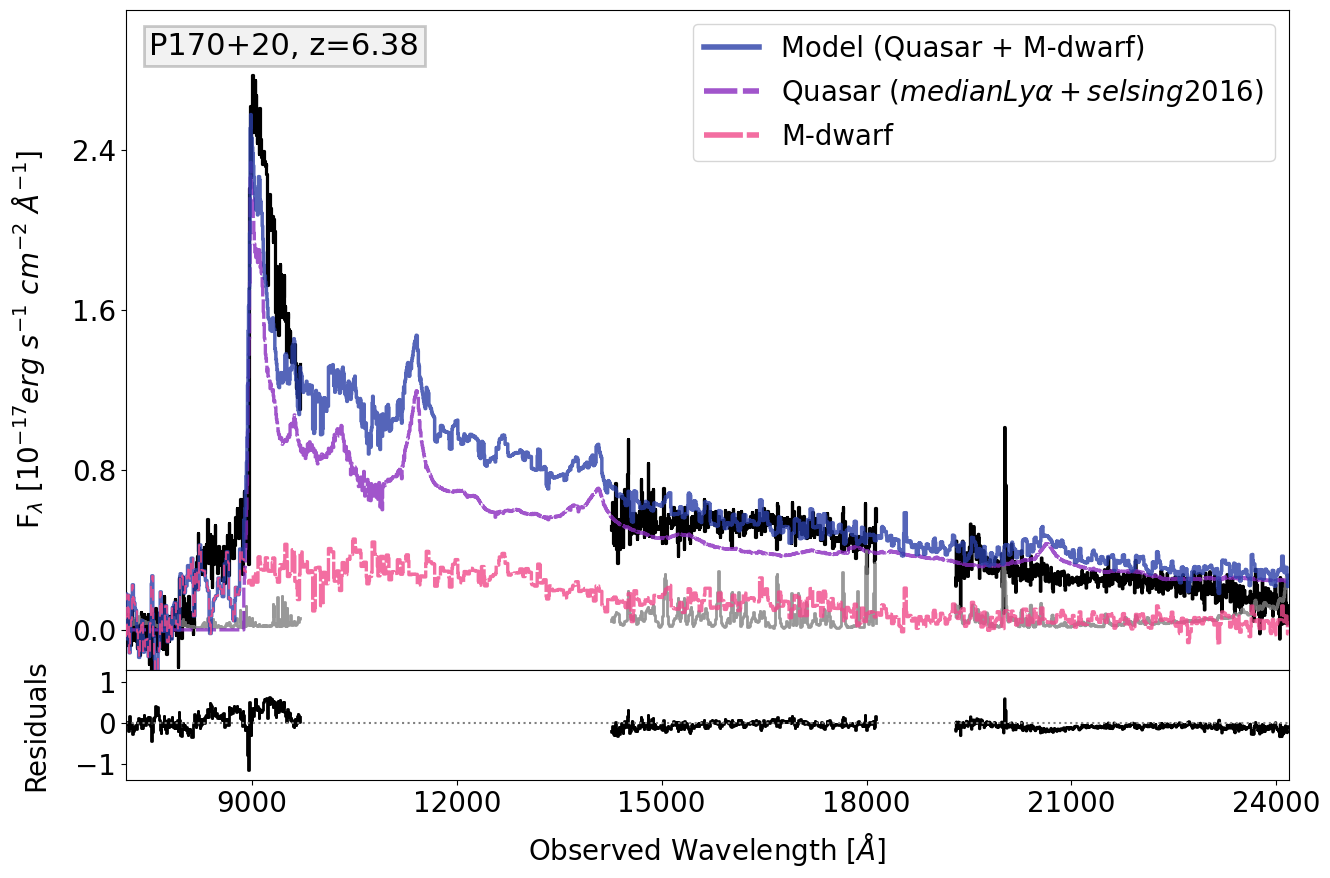

In [22]:
    from matplotlib.ticker import MaxNLocator
    import matplotlib.ticker as ticker
    import matplotlib.gridspec as gridspec
    import astropy.units as units
    from specutils.manipulation import FluxConservingResampler
    from specutils import Spectrum1D
    import os
    from astropy.table import Table
    tabla =Table.read('/mnt/c/Users/aurom/Downloads/Auroracodesthatwork/MBD/BDtemplates/2MASSJ18112466p374851320030522BUR04B', format='ascii')
    #Table.read('\\Users\\aurom\\Downloads\\Auroracodesthatwork\\MBD\\BDtemplates\\2MASSJ18112466p374851320030522BUR04B', format='ascii')
    #Try to do the resample here
    #Include resample data/ pix_size=7.7
    #First Give units to variables with filtered data
    #Total data
    newfluxbd=tabla['col2']*1e-17*units.erg/units.s/units.cm**2/units.AA
    newwavebd=tabla['col1']*1e4*units.AA
    newerrbd=tabla['col3']*1e-17*units.erg/units.s/units.cm**2/units.AA
    
    #convert to Spectrum from specutils 
    input_specbd=Spectrum1D(spectral_axis=newwavebd,flux=newfluxbd) 
    input_spec_errbd=Spectrum1D(spectral_axis=newwavebd,flux=newerrbd)
    
    #Resample here
    fluxconbd = FluxConservingResampler()
    new_spec_fluxconbd = fluxconbd(input_specbd, new_disp_grid)
    #new_spec_fluxcon_errbd = fluxconbd(input_spec_errbd, new_disp_grid)
    maskcurve=(originaldata_wave>969.47*(z+1))&(originaldata_wave<1210*(1+z))
    bdspectra=new_spec_fluxconbd.flux.value[maskcurve]
    
    def databrownd(x,c):
        f = c*bdspectra
        return f


    popt,pcov=curve_fit(databrownd,xdata=originaldata_wave[maskcurve],ydata=originaldata_flux[maskcurve],p0=[2.2])
    factorcbd=popt[0]
    
    # #Average bd
    # mask_a3=(originaldata_wave>16200)&(originaldata_wave<16400) 
    # mask_bt=(16200<new_spec_fluxconbd.spectral_axis.value)&(16400>new_spec_fluxconbd.spectral_axis.value)
    
    # av_qso3=np.mean(residual3[mask_a3])
    # av_bdm=np.mean(new_spec_fluxconbd.flux.value[mask_bt])
    # factorbdm3=av_qso3/av_bdm

    #####################
    maskresqso1=(originaldata_wave>1215*(1+z))&(originaldata_wave<1330*(1+z))
    maskresqso2=(originaldata_wave>1940.29*(z+1))&(originaldata_wave<2469.47*(z+1))
    maskresqso3=(originaldata_wave>2618.72*(z+1))&(originaldata_wave<3283.58*(z+1))
    maskresqso=maskresqso1|maskresqso2|maskresqso3
    bdscale=new_spec_fluxconbd.flux.value*factorcbd
    residualbddata=originaldata_flux-bdscale
    residualbddatac=tabc['FLUX'][maskresqso]

    def residual(x,c):
        f = c*residualbddatac
        return f
    
    
    #mask_no_nan = ~np.isnan(tabc['FLUX'])
    popt2,pcov2=curve_fit(residual,xdata=originaldata_wave[maskresqso],ydata=residualbddata[maskresqso],p0=[4.2])
    factorcresqso=popt2[0]
    print('factor cbd', factorcbd)
    print('factor qso', factorcresqso)
    # tabc = astropy.table.Table()
    # tabc['WAVE']= np.append(composite_wave[maskpr],wl[maskcs2])
    # tabc['FLUX']= np.append(composite_flux[maskpr],weighted_mean[maskcs2]*factorcresqso)
    ###########


    #sumspectra my model
    browndspectra=new_spec_fluxconbd.flux.value*factorcbd#*factorbdm3
    sumspectra=np.nan_to_num(browndspectra+(tabc['FLUX']*factorcresqso))#d
    substraction=originaldata_flux-sumspectra
    originaldata_err=new_spec_fluxcon_err.flux.value
    
    
    mask1= (originaldata_wave>7156.777)&(originaldata_wave<9710)
    mask2= (originaldata_wave>14250)&(originaldata_wave<18150) 
    mask3= (originaldata_wave>19300)&(originaldata_wave<24181.477) 


    #Calculation of chi square
    maskf= mask1 | mask2 | mask3
    #chisquare=np.sum(substraction[maskf])**2/np.std(originaldata_flux[maskf])**2
    #reducedchi=chisquare/len(originaldata_flux[maskf])-2
    chisquare=np.sum((substraction[maskf])**2/((originaldata_err[maskf])**2))
    reducedchi=chisquare/(len(originaldata_flux[maskf])-2)
    print(r'$\chi^2$='+str(np.round(reducedchi,3)))


    #All plotting from here
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.5])
    
    ax1 = fig.add_subplot(gs[0])
    maskla=(originaldata_wave>8924)
    maskla2=(originaldata_wave<8924)
    #Primer parte
    ax1.step(originaldata_wave[mask1],originaldata_flux[mask1],color='black',linewidth=2.3,zorder=0)
    ax1.step(originaldata_wave[mask1], originaldata_err[mask1] ,color='grey',alpha=0.8,linewidth=2)

    ax1.step(originaldata_wave,sumspectra,label='Model (Quasar + M-dwarf)',alpha=0.8,color='#2A3FA8',linewidth=2.5,zorder=3)
    ax1.step(originaldata_wave,tabc['FLUX']*factorcresqso,label='Quasar ($medianLyα + selsing2016$)',alpha=0.8,color='#8A2BBF',linewidth=2.4,dashes=[6, 1])
    ax1.step(originaldata_wave[maskla],browndspectra[maskla],label='M-dwarf',alpha=0.8,color="#F04A8A",linewidth=2.4,linestyle='-', dashes=[7, 0.7],zorder=3)
    ax1.step(originaldata_wave[maskla2],browndspectra[maskla2],alpha=0.95,color="#F04A8A",linewidth=1.2,linestyle='-', dashes=[7, 4],zorder=3)

    
    #Segunda parte
    ax1.step(originaldata_wave[mask2],originaldata_flux[mask2],color='black',linewidth=2.3,zorder=0)
    ax1.step(originaldata_wave[mask2], originaldata_err[mask2] ,color='grey',alpha=0.8,linewidth=2)
    
    #ax1.step(originaldata_wave[mask2],tabc['FLUX'][mask2]*factorcresqso,alpha=0.5,color='green',linewidth=2)
    #ax1.step(originaldata_wave[mask2],browndspectra[mask2],alpha=0.9,color='pink',linewidth=2.2,linestyle='--',zorder=3)
    #ax1.step(originaldata_wave[mask2],sumspectra[mask2],alpha=0.7,color='cornflowerblue',linewidth=2)
    
    #Tercera parte
    ax1.step(originaldata_wave[mask3], originaldata_flux[mask3],color='black',linewidth=2.3,zorder=0)
    ax1.step(originaldata_wave[mask3], originaldata_err[mask3] ,color='grey',alpha=0.8,linewidth=2.3,zorder=1)
    
    #ax1.step(originaldata_wave[mask3],tabc['FLUX'][mask3]*factorcresqso,alpha=0.5,color='green',linewidth=2)
    #ax1.step(originaldata_wave[mask3],browndspectra[mask3],color='brown',linewidth=2)
    #ax1.step(originaldata_wave[mask3],sumspectra[mask3],color='cornflowerblue',linewidth=2)
    
    
    ax1.tick_params(labelbottom=False) 
    bbox=dict(facecolor='silver',   # Color de fondo
                  edgecolor='black',          # Borde
                  linewidth=2,
                  alpha=0.2)
    ax1.text(0.02,0.945,'P170+20, z=6.38',va='center', rotation='horizontal',fontsize=22,bbox=bbox,transform=ax1.transAxes)
    ax1.set_ylabel('F$_{\lambda}$ $[10^{-17} erg~s^{-1}~cm^{-2}~\AA^{-1}]$',fontsize=20,labelpad=18)
    ax1.yaxis.set_tick_params(labelsize=20)
    #ax1.set_ylabel('$f_{\lambda}$ $(10^{-17} erg~s^{-1}~cm^{-2}~\AA^{-1})$',fontsize=16)
    ax1.set_xlim(7156.777,24181.477)
    ax1.set_ylim(-0.2e-17,3.1e-17)

    #ax1.plot(originaldata_wave,  residual3,label='Substraction data-templates' )

 
    
    
    
    #Lower plot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.step(originaldata_wave[mask1],substraction[mask1],color='black',linewidth=2)
    ax2.step(originaldata_wave[mask2],substraction[mask2],color='black',linewidth=2)
    ax2.step(originaldata_wave[mask3],substraction[mask3],color='black',linewidth=2)
    ax2.axhline(y=0,color='grey',linestyle='dotted')
    #ax2.plot([7156.777, 9736.701], [0, 0], color='grey', linestyle='dotted')
    #ax2.plot([14250, 18150], [0, 0], color='grey', linestyle='dotted')
    #ax2.plot([19300, 24181.477], [0, 0], color='grey', linestyle='dotted')
    ax2.xaxis.set_tick_params(labelsize=20)
    #ax2.set_title('Original data-(QSO template + Brown Dwarf)')
    ax2.set_ylim(-1.4e-17, 1.3e-17)
    #ax2.legend(fontsize=14)
    ax2.get_yaxis().get_offset_text().set_visible(False)
    #ax2.set_ylabel('Residuals',fontsize=16)
    ax2.set_xlim(7156.777,24181.477)

    #ax2.text(0.03, 0.95, '$\chi^2$='+str(np.round(reducedchi,3)), transform=ax2.transAxes,
             #fontsize=10, verticalalignment='top')
    
    
    #fig.text(-0.015, 0.5, '$F_{\lambda}$ $[10^{-17} erg~s^{-1}~cm^{-2}~\AA^{-1}]$', va='center', rotation='vertical',fontsize=20)
    
    ax2.set_ylabel('Residuals',fontsize=20,labelpad=18)
    ax1.get_yaxis().get_offset_text().set_visible(False)
    ax1.get_xaxis().get_offset_text().set_visible(False)
    
    #ax1.ticklabel_format(useOffset=False)

    plt.xlabel(r'Observed Wavelength [$\AA$]',fontsize=20,ha='center', va='center',labelpad=23)
    #plt.xscale('log') #Graficar en log
    plt.subplots_adjust(hspace=0.0)
    #plt.xscale('log')
    
    ax2.yaxis.set_tick_params(labelsize=20)
    #Numero de ticks
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=5))
    
    ax1.legend(fontsize=19.9,loc='upper right')
    leg = ax1.legend(fontsize=19.9)
    for line in leg.get_lines():
        line.set_linewidth(4)

    plt.savefig('\MBD',bbox_inches='tight',dpi=400) 
